**Table of contents**<a id='toc0_'></a>    
- 1. [Giới thiệu về hướng triển khai](#toc1_)    
- 2. [Hàm tiện ích](#toc2_)    
  - 2.1. [Hàm pipelines xử lý dữ liệu](#toc2_1_)    
    - 2.1.1. [Thao tác file](#toc2_1_1_)    
    - 2.1.2. [Tạo đặc trưng](#toc2_1_2_)    
  - 2.2. [Một số utils khác](#toc2_2_)    
  - 2.3. [Data Augmentation](#toc2_3_)    
- 3. [Xử lý data](#toc3_)    
  - 3.1. [Features Extraction](#toc3_1_)    
    - 3.1.1. [Helpers](#toc3_1_1_)    
    - 3.1.2. [Pre Event](#toc3_1_2_)    
    - 3.1.3. [Main Event](#toc3_1_3_)    
    - 3.1.4. [Post Event](#toc3_1_4_)    
    - 3.1.5. [Luồng tổng hợp](#toc3_1_5_)    
  - 3.2. [Full pipelines](#toc3_2_)    
  - 3.3. [Chia train-test](#toc3_3_)    
  - 3.4. [Điều chỉnh nhãn](#toc3_4_)    
- 4. [Huấn luyện mô hình](#toc4_)    
  - 4.1. [Setup hyper-parameters](#toc4_1_)    
  - 4.2. [Huấn luyện (fit)](#toc4_2_)    
    - 4.2.1. [Basic Classifiers - Surface](#toc4_2_1_)    
  - 4.3. [Dự đoán trên tập test](#toc4_3_)    
  - 4.4. [Đánh giá](#toc4_4_)    
    - 4.4.1. [Đánh giá trên tập validation (Out of Fold)](#toc4_4_1_)    
    - 4.4.2. [Đánh giá trên tập test (Average Proba)](#toc4_4_2_)    
- 5. [Xuất](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Giới thiệu về hướng triển khai](#toc0_)

- Mục tiêu: tìm hiểu mô hình và xác lập kỳ vọng
  
- Mô hình sử dụng: <strong>LightGBM</strong>

- Quy trình thực hiện:

    - <strong>(✓) 0.</strong> Chuẩn bị dữ liệu (extinct Flux)
    - <strong>1.1 Features Engineering</strong>, cụ thể gồm:
        - <strong>(✓)</strong> Phân tách cụm thời gian (theo màu quan sát), xác định Main-Event và Pre / Post Event
        - <strong>(✓)</strong> Khai thác đặc trưng về đặc điểm nền tảng của ngôi sao (Pre-event)
        - <strong>(✓)</strong> Khai thác đặc trưng về đặc điểm sự kiện (Main-event), như tốc độ tăng sáng, sự chuyển dịch màu,...
        - <strong>(✓)</strong> Khai thác đặc trưng về đặc điểm hậu sự kiện (Post-event), như lượng bức xạ còn tồn dư,...
        - Một số đặc trưng khác muốn điều tra độ hiệu quả: liên quan chuỗi thời gian, tốc độ thay đổi (shifting), mức độ thay đổi (color centroid, flux,...)
    - <strong>1.2</strong> Tối ưu việc sử dụng dataset
        - <strong>(✓)</strong> Theo hướng <strong>sampling</strong>: lấy mẫu ngẫu nhiên <strong>without replacement</strong> (no duplicate time-filter)
            - Kết luận: không hiệu quả, do đánh mất một số phân phối sự kiện quan trọng.
        - <strong>(✓)</strong> Sử dụng SMOTE cho nhãn TDE:
            - Kết luận: không đáng kể, smote mạnh tay thì làm sai đặc trưng, smote yếu thì không tạo đủ đặc tính chung cho bộ dữ liệu ban đầu.
        - Pseudo-Labeling: dự đoán trên submission, và lọc lại các sample có độ chắc chắn cao (khả năng là đã đúng), để bổ sung cho tập huấn luyện
    - <strong>(✓) 2</strong> Xử lý data
    - <strong>(✓) 3</strong> Xây dụng model: LightGBM
    - <strong>(✓) 4</strong> Thử nghiệm và đánh giá model (chưa tuning)

- Kết luận: Mô hình đang overfitting, thể hiện không đồng đều trong train - validate & test - submission. Nguyên nhân có thể bao gồm:
    - Feature Engineering chưa đủ tốt. Hoặc do hướng tiếp cận (phân chia 3 hồi Pre-Main-Post) làm mất liên kết tổng thể trong dữ liệu
    - Mô hình LGBM học kém. Mặc dù overfitting, song không đồng nghĩa với mô hình quá mạnh với lượng dữ liệu này, mà có thể đang bị mis-guided trong xác định đặc trưng quan trọng
    - Do người thực hiện :v

- Submission: kết quả tốt nhất đạt 0.47, nhưng trong tình trạng unknown-fit.

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as path

from typing import Callable

pd.set_option('display.max_columns', None)

# Preparation for correct Flux (explain later)
# !pip -q install extinction==0.4.7
from extinction import fitzpatrick99
WAVELENGTHS = { ## sourced from SVO Filter Profile Service
    'u': 3641,
    'g': 4704,
    'r': 6155,
    'i': 7504,
    'z': 8695,
    'y': 10056
}


## Chuẩn bị dir (để truy cập file khi cần)
dirname = {
    'root': './kaggle/input', # input dir
    'working': './kaggle/working/',   # current session's saving file dir
}
train_sp_name = 'train_full_lightcurves.csv'
test_sp_name = 'test_full_lightcurves.csv'


## Tải train_log
train_log = pd.read_csv(
    path.join( dirname['root'], 'train_log.csv' )) # ví dụ load file

train_log = train_log.drop(['English Translation', 'target'], axis=1) # lọc cột thừa 
train_log['Z_err'] = train_log['Z_err'].fillna(0)

## Tải test_log



In [42]:
train_log.head(3)


,object_id,Z,Z_err,EBV,SpecType,split
0,Dornhoth_fervain_onodrim,3.0490,0.0,0.110,AGN,split_01
1,Dornhoth_galadh_ylf,0.4324,0.0,0.058,SN II,split_01
2,Elrim_melethril_thul,0.4673,0.0,0.577,AGN,split_01


# 2. <a id='toc2_'></a>[Hàm tiện ích](#toc0_)

In [43]:
sample_log = train_log[train_log['object_id'].isin(['amon_imloth_luin', 'cirion_ira_Ithil', 'cuin_haudh_cenedril']) ]
sample_log

,object_id,Z,Z_err,EBV,SpecType,split
12,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01
27,cirion_ira_Ithil,0.3325,0.0,0.023,SN Ia,split_01
30,cuin_haudh_cenedril,0.5366,0.0,0.013,AGN,split_01


## 2.1. <a id='toc2_1_'></a>[Hàm pipelines xử lý dữ liệu](#toc0_)


### 2.1.1. <a id='toc2_1_1_'></a>[Thao tác file](#toc0_)

- <strong>join_DataFrame (<i> df_log, df_split </i>)</strong> : liên kết log và split thành một bảng thống nhất

- <strong>jurassic_park (<i> row </i>)</strong> : hàm chỉnh sửa Flux (dust EBV extinction)

- <strong>process_and_combine_splits (<i> df_log, on_file, callback_func </i>)</strong> : đọc log và tự tìm đến file split tương ứng (dựa theo tên <i>on_file</i>)

- <strong>basic_process(<i> df_log, df_split </i>)</strong> : một đầu vào khả thi cho call_func của <strong><i>process_and_combine_splits</i></strong>, thực hiện join 2 DataFrame và khử Flux

In [44]:
from scipy import stats, integrate

# Hằng số vũ trụ học (Planck 2018)
H0 = 67.4       
Om0 = 0.315    
CLIGHT = 299792.458

def jurassic_park(df:pd.DataFrame):
    """
    Áp dụng hiệu chỉnh tuyệt chủng (Extinction Correction) vector hóa.
    Đầu vào: DataFrame chứa cột 'Flux', 'Flux_err', 'Filter', 'EBV'.
    Đầu ra: DataFrame đã cập nhật Flux và Flux_err.
    """

    # 2. Tính hệ số R_lambda cho từng Filter
    # A_lambda = fitzpatrick99(wave, Rv * EBV)
    # Ta tính trước A_lambda tại EBV=1 và Rv=3.1 để ra hệ số cố định cho mỗi filter
    # Vì hàm fitzpatrick99 thường nhận numpy array bước sóng (Angstrom)
    
    extinction_coeffs = {}
    for flt, wave in WAVELENGTHS.items():
        # Gọi hàm fitzpatrick99 với 1 giá trị bước sóng, Rv=3.1 (Milky Way), giả định EBV=1 để lấy hệ số
        # Lưu ý: fitzpatrick99 thường yêu cầu input là mảng numpy
        try:
            # Code này tùy thuộc vào implementation của fitzpatrick99 mà bạn đang dùng
            # Kết quả trả về là độ giảm Magnitude cho EBV=1
            coeff = fitzpatrick99(np.array([wave]), 3.1)[0] 
        except:
            # Fallback nếu hàm fitzpatrick99 của bạn có cú pháp khác
            # Đây là logic: A_lambda = Coeff * EBV
            pass 
        extinction_coeffs[flt] = coeff

    # 3. Map hệ số vào DataFrame
    # Tạo cột tạm chứa hệ số R tương ứng với Filter của dòng đó
    df['ext_coeff'] = df['Filter'].map(extinction_coeffs)

    # 4. Tính Scale Factor: 10^(A_lambda / 2.5)
    # A_lambda_thuc_te = ext_coeff * EBV
    df['scale_factor'] = 10 ** ((df['ext_coeff'] * df['EBV']) / 2.5)

    # 5. Áp dụng hiệu chỉnh cho cả Flux và Flux_err
    df['Flux'] = df['Flux'] * df['scale_factor']
    df['Flux_err'] = df['Flux_err'] * df['scale_factor']

    # 6. Dọn dẹp
    df.drop(columns=['ext_coeff', 'scale_factor'], inplace=True)
    
    return df

def get_luminosity_distance(z):
    """Tính khoảng cách độ chói (Luminosity Distance) theo Redshift."""
    if z <= 0: return 0
    inv_E = lambda x: 1.0 / np.sqrt(Om0 * (1 + x)**3 + (1 - Om0))
    dc, _ = integrate.quad(inv_E, 0, z)
    return (CLIGHT / H0) * dc * (1 + z)

def calculate_distance_modulus(z_array):
    """Vector hóa hoặc Map việc tính Distance Modulus."""
    unique_zs = np.unique(z_array)
    dist_map = {}
    for z in unique_zs:
        d_L_Mpc = get_luminosity_distance(z)
        if d_L_Mpc > 0:
            mu = 5 * np.log10(d_L_Mpc) + 25
        else:
            mu = np.nan
        dist_map[z] = mu
    return dist_map

def preprocess_lightcurves(df):
    """
    Ánh xạ Filter -> Bước sóng, tính Rest-frame và phân loại Bin.
    """
    df = jurassic_park(df)
    flux_col = 'Corrected Flux' if 'Corrected Flux' in df.columns else 'Flux'
    
    # 1. Physics Mapping (Filter -> Wavelength)
    # Lấy từ dict WAVELENGTHS toàn cục
    df['lambda_obs'] = df['Filter'].map(WAVELENGTHS)
    
    # 2. Tính Rest-frame Wavelength
    # lambda_rest = lambda_obs / (1 + z)
    df['lambda_rest'] = df['lambda_obs'] / (1 + df['Z'])
    
    # 4. Magnitude & Luminosity (Giữ nguyên logic cũ)
    dist_map = calculate_distance_modulus(df['Z'].values)
    df['dist_mod'] = df['Z'].map(dist_map)
    
    m_apparent = np.full(len(df), np.nan)
    mask_pos = df[flux_col] > 0
    m_apparent[mask_pos] = -2.5 * np.log10(df.loc[mask_pos, flux_col]) + 23.9
    df['m_apparent'] = m_apparent
    df['M_abs'] = df['m_apparent'] - df['dist_mod']
    df['Log_Luminosity'] = -0.4 * df['M_abs']

    # 5. Time Normalization
    df = df.sort_values(by=['object_id', 'Time (MJD)'])
    t0 = df.groupby('object_id')['Time (MJD)'].transform('min')
    df['Time (MJD)'] = (df['Time (MJD)'] - t0) / (1 + df['Z'])
    
    return df.drop(['lambda_obs'], axis=1)


In [45]:
def join_DataFrame (df_log:pd.DataFrame, df_split:pd.DataFrame) :
    return pd.merge(
                left= df_log,          # Bảng 1 (Thông tin tĩnh - Left Table)
                right= df_split,    # Bảng 2 (Thông tin chuỗi thời gian - Right Table)
                on='object_id',          # Cột dùng để nối (Khóa chung)
                how='right'              # Loại phép nối: Right Join (Giữ tất cả dòng của Bảng 2)
        ).dropna()

def process_and_combine_splits(
    df_log: pd.DataFrame,
    on_file: str,
    callback_function: Callable[[pd.DataFrame, pd.DataFrame], pd.DataFrame]
) -> pd.DataFrame:
    """
    Nhóm DataFrame tĩnh theo cột 'split', đọc file CSV tương ứng,
    nối hai bảng, áp dụng hàm callback, và nối kết quả.

    Args:
        df_log: DataFrame gốc (Bảng 1) chứa thông tin 'split'.
        on_file: tên file trong folder split (test_full_lightcurves.csv hoặc train_full_lightcurves.csv)
        callback_function: Hàm (F) áp dụng lên 2 DataFrame sau khi được phân nhóm split, lần lượt là log_chunk và split
                eg: callback_function( df_log, df_split)
    Returns:
        DataFrame cuối cùng đã được nối và xử lý.
    """
    
    # 1. Nhóm DataFrame tĩnh theo cột 'split'
    grouped_logs = df_log.groupby('split')
    
    results_list = []

    # 2. Lặp qua từng nhóm
    for split_name, df_log_chunk in grouped_logs:
        # print(f"--- Đang xử lý nhóm: {split_name} ---")
        
        # 3a. Đọc file CSV (Bảng 2)
        df_split = pd.read_csv(
                path.join( dirname['root'], split_name, on_file ))
            
        # 3c. Áp dụng hàm callback (F)
        # Hàm F có thể thực hiện hiệu chỉnh Flux, merge 2 bảng,.. v.v.
        df_processed_chunk = callback_function(df_log_chunk, df_split, split_name)
        
        # Thêm kết quả đã xử lý vào danh sách
        results_list.append(df_processed_chunk)
        
        # print(f"Hoàn tất xử lý nhóm {split_name}. Kích thước: {len(df_processed_chunk)} dòng.")

    # 4. Nối toàn bộ sản phẩm của các group thành một DataFrame thống nhất
    if not results_list:
        return pd.DataFrame()
        
    final_df = pd.concat(results_list, ignore_index=True)
    
    return final_df

def basic_process(df_log:pd.DataFrame, df_split:pd.DataFrame, split_name:str) :
    df_full_join = join_DataFrame(df_log, df_split)

    df_prepocessed = preprocess_lightcurves(df_full_join)
    
    return df_prepocessed.drop(['Z_err', 'split'], axis = 1)
    


sample_log_raw = process_and_combine_splits(
    sample_log,
    'train_full_lightcurves.csv',
    basic_process
)

sample_log_single_object = sample_log_raw.groupby('object_id').get_group('amon_imloth_luin')

sample_log_raw

,object_id,Z,EBV,SpecType,Time (MJD),Flux,Flux_err,Filter,lambda_rest,dist_mod,m_apparent,M_abs,Log_Luminosity
0,amon_imloth_luin,0.7766,0.055,TDE,0.000000,-0.137194,0.301567,z,4894.179894,43.489552,NaN,NaN,NaN
1,amon_imloth_luin,0.7766,0.055,TDE,5.492908,-0.066016,0.174910,r,3464.482720,43.489552,NaN,NaN,NaN
2,amon_imloth_luin,0.7766,0.055,TDE,6.866149,0.849852,0.943070,y,5660.249916,43.489552,24.076642,-19.412910,7.765164
3,amon_imloth_luin,0.7766,0.055,TDE,8.239390,-0.295371,0.910495,y,5660.249916,43.489552,NaN,NaN,NaN
4,amon_imloth_luin,0.7766,0.055,TDE,8.239390,-0.625070,0.536389,z,4894.179894,43.489552,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,cuin_haudh_cenedril,0.5366,0.013,AGN,1662.113107,0.108060,0.414702,u,2369.517116,42.515961,26.315840,-16.200120,6.480048
430,cuin_haudh_cenedril,0.5366,0.013,AGN,1662.113107,0.106927,0.088131,g,3061.304178,42.515961,26.327281,-16.188680,6.475472
431,cuin_haudh_cenedril,0.5366,0.013,AGN,1670.797084,0.084996,0.177624,r,4005.596772,42.515961,26.576502,-15.939459,6.375784
432,cuin_haudh_cenedril,0.5366,0.013,AGN,1670.797084,0.021165,0.186825,i,4883.509046,42.515961,28.085951,-14.430010,5.772004


### 2.1.2. <a id='toc2_1_2_'></a>[Tạo đặc trưng](#toc0_)

- <strong>extract_features_for_single_object ( <i>object_id, df_object </i>)</strong> : extract features cho một sample. Toàn bộ input được coi là phạm vi dữ liệu gốc để khai thác, tất cả được trả ra dưới tên là đặc trưng của object_id.

## 2.2. <a id='toc2_2_'></a>[Một số utils khác](#toc0_)

In [46]:
from typing import List
from sklearn.metrics import confusion_matrix

def score_prediction(ground_truth:pd.Series, prediction:List, labels:List, focus_label:str) :
    df_compare = pd.DataFrame({
        'True label' : ground_truth.values,
        'Prediction' : prediction
    }, index=ground_truth.index)
    confident = {}
    
    # Tính điểm từng label
    for label in labels :
        df_subset = df_compare[df_compare['True label'] == label]
        right = np.sum(df_subset['Prediction'] == label)
        total = len(df_subset)
        print(f'> {label} accuracy: {right}/{total}  ~ {(right/total * 100):.2f}%')
        confident[label] = right / total


    # Tính F1-score
    cm = confusion_matrix(df_compare['True label'] == focus_label, 
                          df_compare['Prediction'] == focus_label, 
                          labels=[False, True])
    TN, FP, FN, TP = cm.ravel()
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0

    print(f'\t>>> F1-score: {F1_score:.2f}\n')
    return confident

In [47]:
from typing import List, Union, Tuple

def plot_probability_distributions(
    proba: np.ndarray,
    label: pd.Series,
    class_names: List[str],
    show_plot: bool = True
) -> None:
    """
    Vẽ ma trận 3x3 biểu đồ phân phối xác suất dự đoán (proba) của 
    mỗi lớp, được nhóm theo nhãn thực tế (label).

    Args:
        proba: Mảng 2D (N_samples, 3) chứa xác suất dự đoán (P_SN, P_AGN, P_TDE).
        label: Mảng 1D (N_samples) chứa nhãn thực tế (dạng chuỗi).
        class_names: Danh sách tên 3 lớp tương ứng với 3 cột xác suất.
    """
    N_CLASSES = len(class_names)

    # 1. Chuyển đổi thành DataFrame
    df = pd.DataFrame(proba, columns=[f'{name}' for name in class_names]).set_index(label.index)
    df['Prediction'] = pd.Series([class_names[i] for i in np.argmax(proba, axis=1)], index=label.index)
    df['True Label'] = label.values

    if not show_plot :
        return df

    # 2. Thiết lập bố cục biểu đồ (3 hàng, 3 cột)
    fig, axes = plt.subplots(N_CLASSES, N_CLASSES, figsize=(24, 15), constrained_layout=True)


    # i: index hàng (tương ứng với nhãn thực tế)
    for i, true_label in enumerate(class_names):
        
        # Lọc dữ liệu theo nhãn thực tế hiện tại
        df_group = df[df['True Label'] == true_label]
        
        # j: index cột (tương ứng với xác suất của lớp j)
        for j, pred_class in enumerate(class_names):
            
            ax = axes[i, j]

            # Vẽ biểu đồ phân phối (KDE plot)
            # kde=True vẽ đường cong, hist=False không vẽ histogram
            # sns.kdeplot(df_group[pred_class], ax=ax, fill=True, color=sns.color_palette("Set2")[j])
            sns.histplot(df_group[pred_class], ax=ax, fill=True, color=sns.color_palette("Set2")[j])
            
            # Đặt tiêu đề cột
            if i == 0:
                ax.set_title(f'Phân phối P({pred_class})', fontsize=10)
            
            # Đặt tiêu đề hàng (nhãn thực tế)
            if j == 0:
                ax.set_ylabel(f'Nhãn Thực tế: {true_label}\n(Mật độ)', fontsize=12, weight='bold')

            # Đặt giới hạn trục x (từ 0 đến 1)
            ax.set_xlim(0, 1)
            ax.axvline(0.5, color='red', linestyle='--', linewidth=0.8) # Đường tham chiếu 0.5
            
            # Xóa nhãn trục y không cần thiết
            if j != 0:
                ax.set_ylabel('')
                
            # Xóa nhãn trục x ở các hàng trên cùng
            if i != (N_CLASSES - 1):
                ax.set_xlabel('')
            else:
                ax.set_xlabel(f'P({pred_class})', fontsize=10)


    plt.suptitle("Phân phối Xác suất Dự đoán theo Nhãn Thực tế (True Label)", fontsize=16, weight='bold', y=1.02)
    plt.show()
    return df

def plot_cluster_and_filter_distribution(list_of_clusters: List[pd.DataFrame], SpecType:str, filter_list=['UV', 'Optical', 'IR']) -> None:
    """
    Vẽ 2 biểu đồ điểm (scatter plots) Flux vs Time (MJD) từ một list các DataFrame cluster.
    
    Biểu đồ 1: Màu sắc theo cột 'Filter'.
    Biểu đồ 2: Màu sắc theo ID của cluster (DataFrame gốc).

    Args:
        list_of_clusters: List chứa các DataFrame, mỗi DF là một cluster.
    """
    
    if not list_of_clusters:
        print("Danh sách các Cluster (DataFrame) rỗng, không thể vẽ biểu đồ.")
        return

    # --- 1. Tổng hợp dữ liệu và tạo cột phân loại ---
    
    all_data = []
    
    # Gán ID duy nhất cho mỗi cluster (DataFrame)
    for i, df_cluster in enumerate(list_of_clusters):
        df_temp = df_cluster[df_cluster['Filter'].isin(filter_list)].copy()
        # Tạo cột Cluster_ID dựa trên vị trí của DF trong List
        df_temp['Cluster_ID'] = f'Cluster_{i+1}' 
        all_data.append(df_temp)
        
    # Nối tất cả các DataFrame thành một DF lớn
    df_combined = pd.concat(all_data, ignore_index=True)

    # 2. Kiểm tra các cột bắt buộc
    required_cols = ['Time (MJD)', 'Flux', 'Filter']
    if not all(col in df_combined.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df_combined.columns]
        print(f"Lỗi: DataFrame thiếu các cột bắt buộc: {missing}. Không thể vẽ biểu đồ.")
        return
        
    # --- 2. Tạo bố cục Biểu đồ (1 hàng, 2 cột) ---
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Đặt tiêu đề chung
    fig.suptitle(
        f'Phân bố Flux của {SpecType}', 
        fontsize=16, 
        fontweight='bold'
    )

    # --- BIỂU ĐỒ 1: Phân loại theo FILTER ---
    
    ax1 = axes[0]
    # Sử dụng Seaborn scatterplot với màu sắc dựa trên cột 'Filter'
    sns.scatterplot(
        data=df_combined,
        x='Time (MJD)',
        y='Flux',
        hue='Filter',  # Màu sắc theo 'Filter'
        ax=ax1,
        s=10,          # Kích thước điểm nhỏ
        alpha=0.7      # Độ trong suốt
    )
    ax1.set_title("Phân bố theo Filter", fontsize=14)
    ax1.set_xlabel("Time (MJD)", fontsize=12)
    ax1.set_ylabel("Flux", fontsize=12)
    ax1.legend(title='Filter', loc='best')

    # --- BIỂU ĐỒ 2: Phân loại theo CLUSTER_ID ---

    ax2 = axes[1]
    # Sử dụng Seaborn scatterplot với màu sắc dựa trên cột 'Cluster_ID'
    # palette='tab10' hoặc 'hsv' nếu có nhiều hơn 10 clusters
    sns.scatterplot(
        data=df_combined,
        x='Time (MJD)',
        y='Flux',
        hue='Cluster_ID',  # Màu sắc theo ID của cluster
        ax=ax2,
        s=10,
        alpha=0.7,
        # Nếu có quá nhiều clusters, hãy tắt legend để tránh lộn xộn
        legend='full' if len(list_of_clusters) <= 15 else False 
    )
    ax2.set_title("Phân bố theo Cluster ID", fontsize=14)
    ax2.set_xlabel("Time (MJD)", fontsize=12)
    ax2.set_ylabel("Flux", fontsize=12)
    if len(list_of_clusters) <= 15:
        ax2.legend(title='Cluster ID', loc='best', ncol=1)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Điều chỉnh layout để tiêu đề chung hiển thị rõ
    plt.show()  

def plot_prediction_confusion_pie(true_label, prediction):
    """
    Vẽ hệ thống biểu đồ tròn 2 hàng x N cột.
    - Hàng 1: Phân phối Dự đoán theo True Label (Recall perspective).
    - Hàng 2: Phân phối True Label theo Prediction (Precision perspective).
    """
    # Chuyển đổi sang Series để dễ xử lý nếu đầu vào là list/numpy array
    if not isinstance(true_label, pd.Series):
        true_label = pd.Series(true_label)
    if not isinstance(prediction, pd.Series):
        prediction = pd.Series(prediction)

    # 1. Lấy danh sách các nhãn duy nhất
    labels = sorted(list(set(true_label.unique()) | set(prediction.unique())))
    n_classes = len(labels)
    
    # 2. Cấu hình màu sắc cố định
    user_colors = ['#ff9999','#66b3ff','#99ff99']
    
    # Map màu cho từng nhãn (nếu nhiều nhãn hơn 3 thì lặp lại màu)
    color_map = {label: user_colors[i] for i, label in enumerate(labels)}

    # 3. Khởi tạo Figure với 2 hàng, N cột
    fig, axes = plt.subplots(2, n_classes, figsize=(6 * n_classes, 10))
    
    # Xử lý trường hợp đặc biệt chỉ có 1 class (axes không phải mảng 2D)
    if n_classes == 1:
        axes = np.array([axes]).reshape(2, 1)

    # --- HÀNG 1: Dựa trên TRUE LABEL (Actual) ---
    for i, target_cls in enumerate(labels):
        ax = axes[0, i]
        
        # Lọc: Lấy tất cả các mẫu CÓ THỰC TẾ là target_cls
        subset_indices = true_label[true_label == target_cls].index
        subset_preds = prediction.loc[subset_indices]
        
        # Đếm xem mô hình dự đoán ra các nhãn nào
        counts = subset_preds.value_counts().reindex(labels, fill_value=0)
        
        # Xử lý hiển thị: Chỉ hiện nhãn nếu count > 0 để đỡ rối
        pie_labels = [f"{lbl}" if val > 0 else "" for lbl, val in zip(counts.index, counts.values)]
        
        ax.pie(
            counts, 
            labels=pie_labels, 
            autopct='%1.1f%%', 
            startangle=140,
            colors=[color_map[lbl] for lbl in counts.index],
            explode=[0.05 if lbl == target_cls else 0 for lbl in counts.index]
        )
        ax.set_title(f"Thực tế là: {target_cls}\n(Actual)", fontsize=13, color='darkblue', fontweight='bold')

    # --- HÀNG 2: Dựa trên PREDICTION (Predicted) ---
    for i, target_cls in enumerate(labels):
        ax = axes[1, i]
        
        # Lọc: Lấy tất cả các mẫu ĐƯỢC DỰ ĐOÁN là target_cls
        subset_indices = prediction[prediction == target_cls].index
        subset_trues = true_label.loc[subset_indices]
        
        # Đếm xem thực tế chúng là nhãn nào
        counts = subset_trues.value_counts().reindex(labels, fill_value=0)
        
        # Xử lý hiển thị
        pie_labels = [f"{lbl}" if val > 0 else "" for lbl, val in zip(counts.index, counts.values)]

        # Nếu không có mẫu nào được dự đoán là class này (chia cho 0), cần handle
        if sum(counts) > 0:
            ax.pie(
                counts, 
                labels=pie_labels, 
                autopct='%1.1f%%', 
                startangle=140,
                colors=[color_map[lbl] for lbl in counts.index],
                explode=[0.05 if lbl == target_cls else 0 for lbl in counts.index]
            )
        else:
            ax.text(0.5, 0.5, "Không có dữ liệu", ha='center', va='center')

        ax.set_title(f"Dự báo là: {target_cls}\n(Prediction)", fontsize=13, color='darkred', fontweight='bold')

    # Tiêu đề chung và Layout
    fig.suptitle('Phân phối chi tiết: Thực tế (Hàng trên) vs Dự báo (Hàng dưới)', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



## 2.3. <a id='toc2_3_'></a>[Data Augmentation](#toc0_)

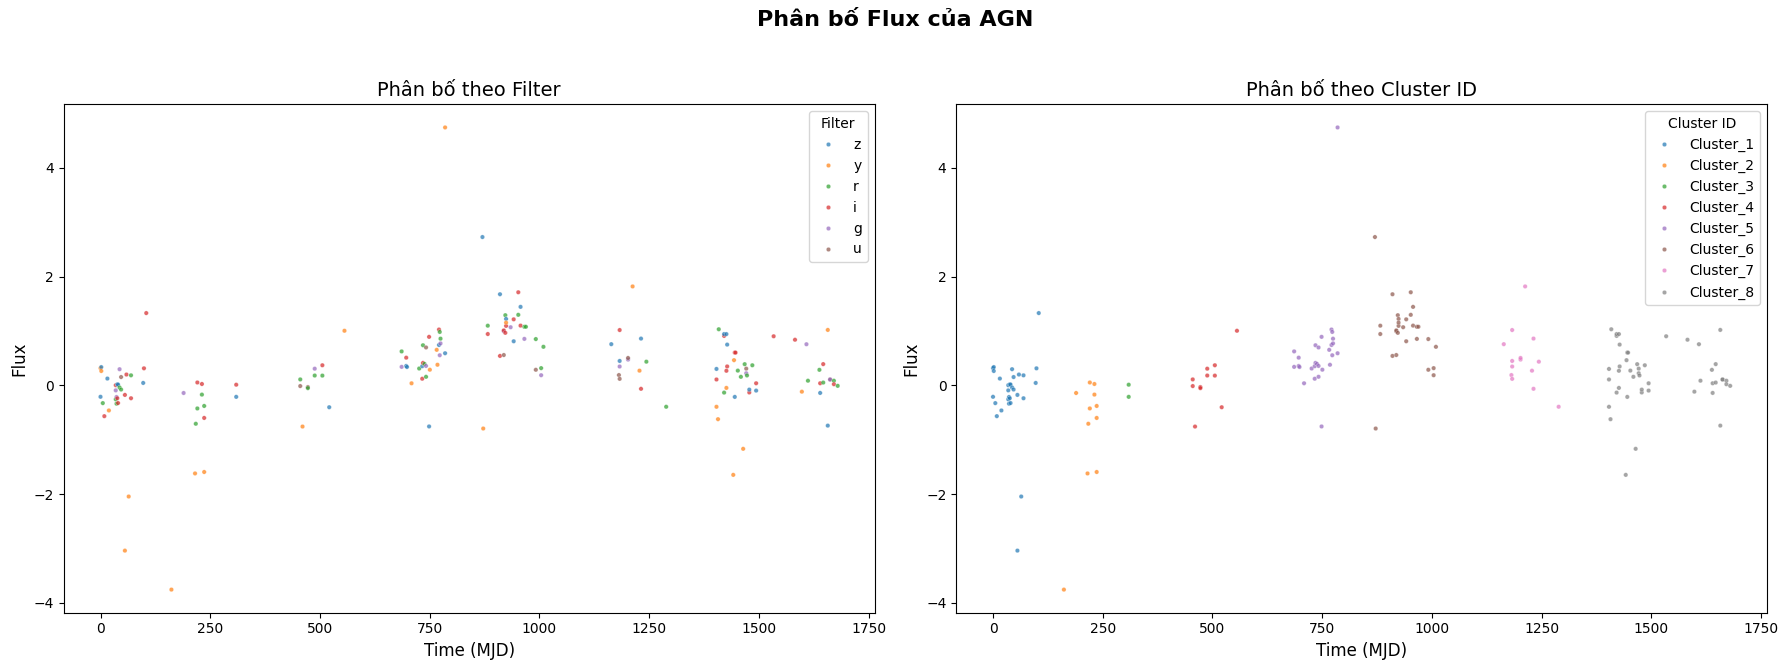

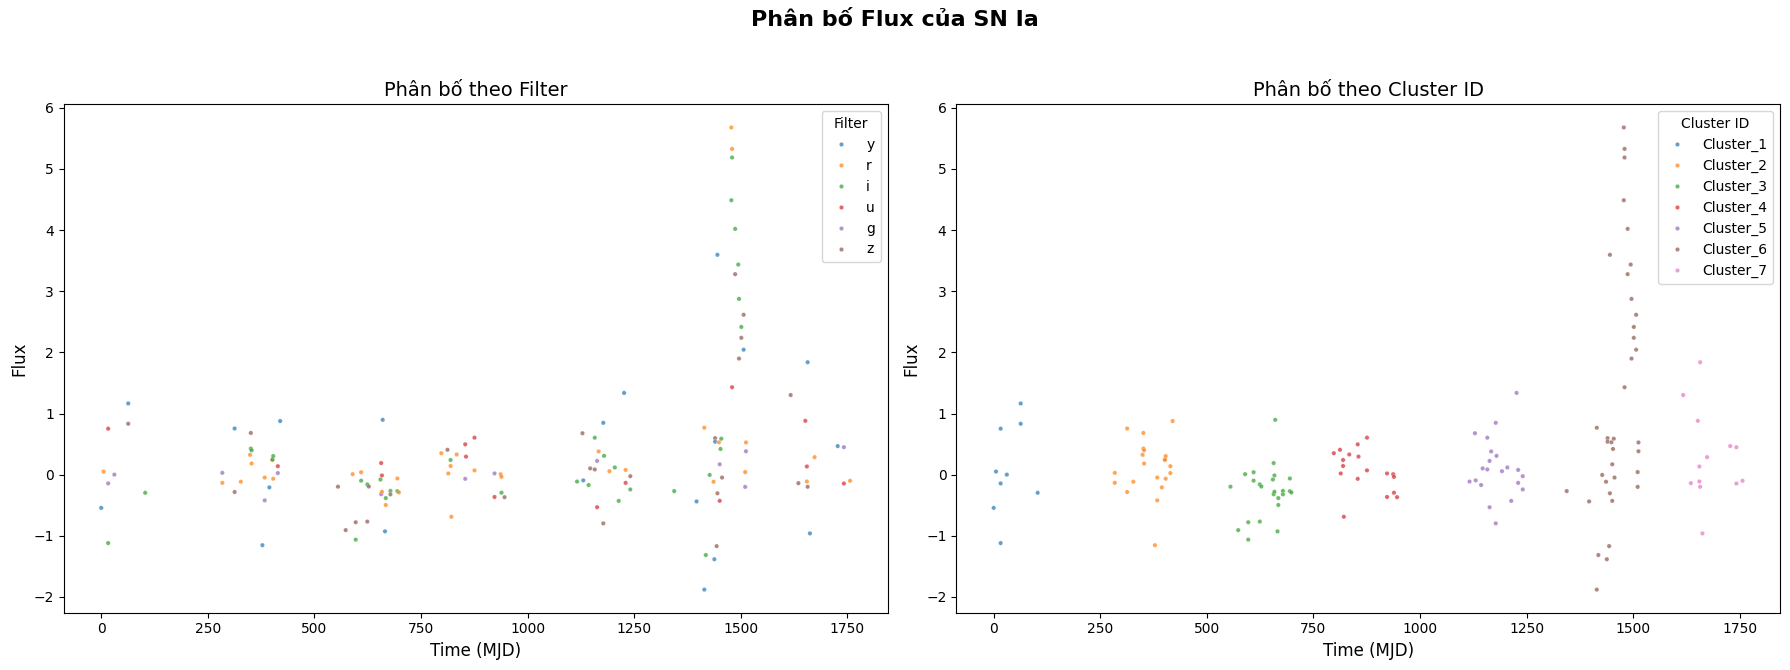

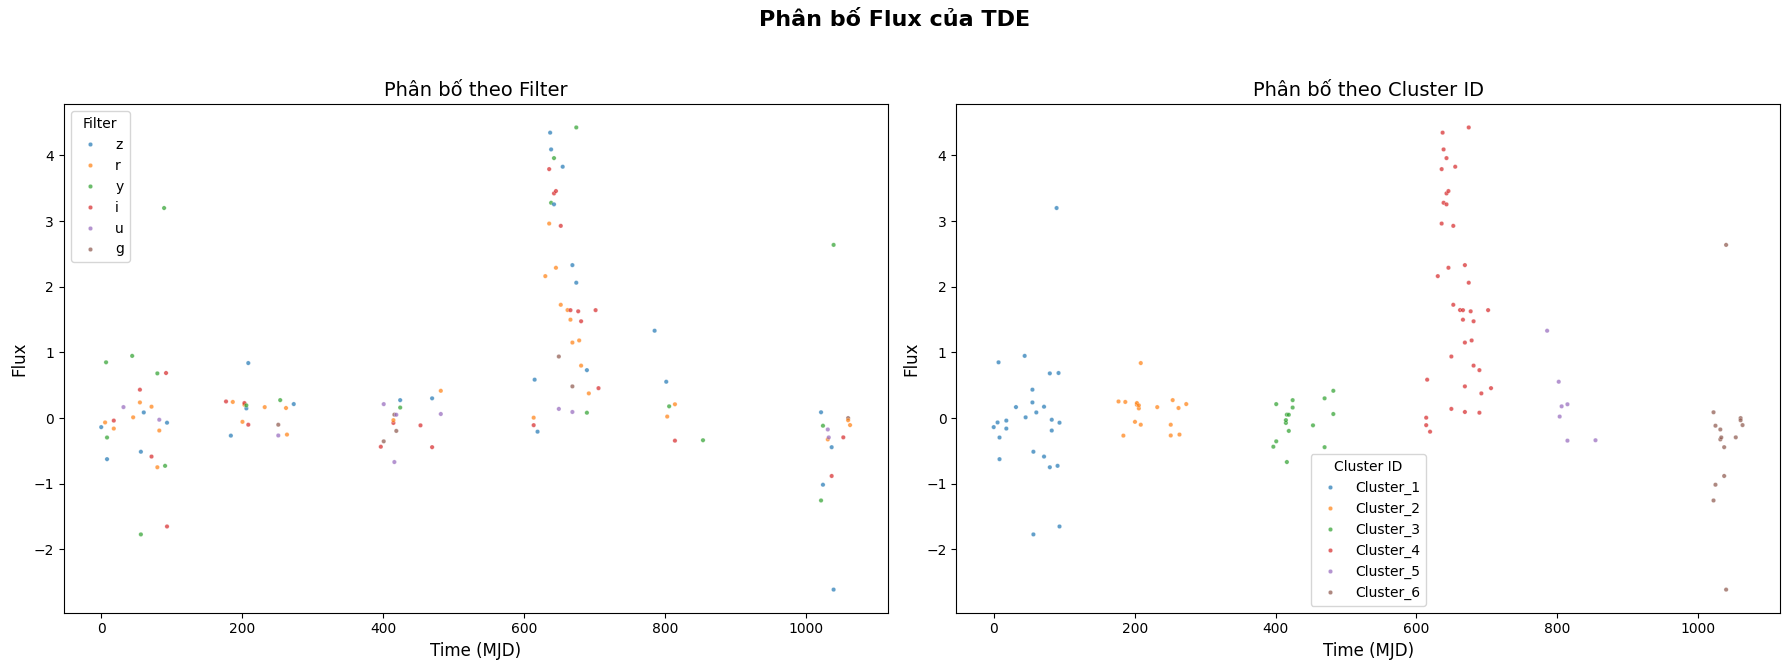

[5, 1, 2]

In [48]:

def random_sampling_split(df_object, required_points, max_sample):
    """
    Tạo các mẫu (splits) bằng cách lấy mẫu ngẫu nhiên (uniform) số lượng điểm 
    nhất định từ mỗi Filter (ống kính).
    
    Args:
        df_object (pd.DataFrame): DataFrame của 1 object_id, đã gộp log và split.
        points_on_each_filter (int): Số dòng/điểm cần lấy trên mỗi filter.
        max_sample (int): Số lượng splits tối đa muốn tạo ra.
        seed (int): Random seed cho việc lấy mẫu.
    
    Returns:
        list: Danh sách các DataFrame nhỏ (splits) đã được lấy mẫu ngẫu nhiên.
    """
    
    # 1. Grouping theo Filter
    grouped = df_object.groupby('Filter')
    
    # 2. Xác định margin (số lượng mẫu dư ra)
    min_group_length = grouped.size().min()
    
    # Số lượng bản ghi cần thiết cho 1 mẫu hoàn chỉnh (đủ tất cả filters)
    margin = min_group_length - required_points
    if not max_sample : max_sample = margin
    
    # 3. Xác định Số lần Lặp
    # margin + 1 là số lượng vị trí bắt đầu có thể có, tính cả vị trí cuối cùng.
    num_iterations = min(margin, max_sample) if margin > 0 else 1
    
    splits = []
    
    # 4. Lấy mẫu ngẫu nhiên các vị trí bắt đầu    
    for _ in range(num_iterations):
        all_filters_sample = []
        
        # Lấy mẫu từ mỗi group
        for filter_name, group in grouped:
            
            sample = group.sample(n=min( len(group), required_points ), 
                                random_state=None) 
            
            all_filters_sample.append(sample)
            
        # Hợp nhất các mẫu từ các filter
        split_df = pd.concat(all_filters_sample, ignore_index=True)
        splits.append(split_df)
        
    return splits

def time_based_clustering_split(df_object):
    """
    Phân tách DataFrame của một object_id thành các cluster dựa trên khoảng cách thời gian 
    lớn hơn ngưỡng: mean(time_diff) + std(time_diff).
    
    Args:
        df_object (pd.DataFrame): DataFrame của 1 object_id, đã gộp log và split.
    
    Returns:
        list: Danh sách các DataFrame cluster.
    """

    # 1. Sắp xếp theo thời gian Time (MJD)
    # Rất quan trọng: Chỉ sắp xếp df_temp, không thay đổi df_object gốc
    df_object = df_object.sort_values('Time (MJD)').reset_index(drop=True)
    
    # 2. Tính time_diff giữa các dòng liên tiếp
    time_diff = df_object['Time (MJD)'].diff()
    
    # 3. Tính Ngưỡng Phân tách (separation_line)
    # Bỏ qua NaN (dòng đầu tiên) khi tính mean và std
    mean_diff = time_diff.mean()
    std_diff = time_diff.std()
    
    # Ngưỡng phân tách
    separation_line = mean_diff + std_diff * 2
    
    # Nếu không có đủ dữ liệu (ví dụ: chỉ 1 dòng), không thể tính toán, trả về toàn bộ
    if np.isnan(separation_line):
        return [df_object]
        
    # 4. Xác định Điểm Chia tách và Tạo Nhãn Cluster
    # Dòng đầu tiên (time_diff=NaN) được xử lý là False (không phải điểm chia tách)
    # mask: True nếu là khoảng nghỉ lớn
    is_split_point = (time_diff >= separation_line)
    is_split_point.iloc[0] = False 
    
    # Tạo Cluster ID: Tăng ID mỗi khi gặp một khoảng nghỉ lớn
    df_object['cluster_id'] = is_split_point.cumsum()
    
    # 5. Tách DataFrame thành List Cluster
    cluster_list = [group.drop(columns='cluster_id') 
                    for name, group in df_object.groupby('cluster_id')]
    
    # Ghi chú về Xử lý Đường Phân tách:
    # Logic cumsum đảm bảo dòng có time_diff > separation_line 
    # (tức là dòng *sau* khoảng nghỉ) sẽ bắt đầu cluster mới (ID tăng). 
    # Dòng liền trước đó (dòng kết thúc cluster cũ) sẽ nằm trong cluster cũ, 
    
    return cluster_list

def identify_event_phases(cluster_list: list[pd.DataFrame]):
    """
    Phân loại các cụm quan sát thành 3 giai đoạn dựa trên đỉnh sáng (Peak Flux).
    
    Args:
        cluster_list: List các DataFrame, mỗi DF là 1 cụm quan sát (output của time_based_clustering_split).
        flux_col: Tên cột dùng để xác định độ sáng cực đại (nên dùng 'Corrected Flux' hoặc 'Flux').
        
    Returns:
        tuple: (pre_main_list, main_cluster_list, post_main_list)
               Mỗi phần tử là một List[DataFrame].
    """
    # 1. Xử lý trường hợp danh sách rỗng
    if not cluster_list:
        return [], [], []

    # 3. Tìm Main Cluster (Cụm chứa Global Max Flux)
    max_flux_val = -np.inf
    main_cluster_idx = -1

    for idx, df in enumerate(cluster_list):
        # Lấy max flux trong cluster hiện tại
        # Cần xử lý NaN nếu có (dù pre-processing nên sạch rồi)
        condition = ( df['Flux'] / df['Flux_err'] ).abs() >= 2
        current_max = df[condition]['Flux'].mean()
        
        if pd.isna(current_max):
            continue
            
        if current_max > max_flux_val:
            max_flux_val = current_max
            main_cluster_idx = idx

    # 4. Phân chia Pre - Main - Post
    if main_cluster_idx == -1:
        # Trường hợp hy hữu: toàn bộ dữ liệu là NaN hoặc rỗng
        return [], cluster_list, [] 
        # Hoặc return [], [], [] tùy strategy, ở đây tôi trả về tất cả vào Main để debug
    
    # List slicing
    pre_main_list = cluster_list[:main_cluster_idx]
    main_cluster_list = [cluster_list[main_cluster_idx]] # Đóng gói vào list để đồng bộ output
    post_main_list = cluster_list[main_cluster_idx+1:]

    return pre_main_list, main_cluster_list, post_main_list
    

##-- Ví dụ sử dụng --   
sample_cluster = []
for SpecType, data in sample_log_raw.groupby('SpecType') :
    plot_cluster_and_filter_distribution(time_based_clustering_split(data), SpecType, filter_list=sample_log_raw['Filter'].unique().tolist())
    if SpecType == 'AGN' :
        sample_cluster = time_based_clustering_split(data)

[len(x) for x in identify_event_phases(sample_cluster)]

# 3. <a id='toc3_'></a>[Xử lý data](#toc0_)



## 3.1. <a id='toc3_1_'></a>[Features Extraction](#toc0_)

### 3.1.1. <a id='toc3_1_1_'></a>[Helpers](#toc0_)

In [49]:
import warnings
from scipy import stats
from scipy.optimize import curve_fit, OptimizeWarning

# ==============================================================================
# 1.1. SHARED HELPERS: STATISTICS & COSMOLOGY
# ==============================================================================

def weighted_mean(values, errors):
    """Tính trung bình có trọng số, xử lý mảng rỗng và lỗi chia cho 0."""
    if len(values) == 0: 
        return np.nan
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        weights = 1.0 / (np.square(errors) + 1e-6)
        sum_weights = np.sum(weights)
        
        if sum_weights == 0:
            return np.nan
            
        return np.sum(values * weights) / sum_weights

def calc_spectral_centroid(df):
    """Tính trọng tâm phổ (Spectral Centroid). Chỉ dùng Flux > 0."""
    mask = (df['Flux'] > 0) & ((df['Flux'] / (df['Flux_err'] + 1e-9)).abs() > 1)
    
    if not mask.any(): 
        return 0.0
    
    flux_masked = df.loc[mask, 'Flux']
    lambda_masked = df.loc[mask, 'lambda_rest']
    
    den = np.sum(flux_masked)
    if den == 0:
        return 0.0
        
    num = np.sum(flux_masked * lambda_masked)
    return num / den

def get_flux_stats(df, threshhold=3, prefix=''):
    """Tính toán thống kê cơ bản về Flux (Median, Quantile)."""

    median = np.nan
    _95th = np.nan
    mean = np.nan

    if not df.empty:
        median = df['Flux'].median()
        _95th = df['Flux'].quantile(0.95)
        mean = df['Flux'].mean()

    return {
        f'{prefix}median_flux': median, 
        f'{prefix}flux_95th': _95th, 
        f'{prefix}mean_flux': mean
    }

def get_snr_stats(df, threshold=5):
    """Tính toán thống kê về Tín hiệu/Nhiễu (SNR)."""
    if df.empty:
        return {'detection_ratio': 0.0, 'median_snr': 0.0}
    
    snr = abs(df['Flux'] / (df['Flux_err'] + 1e-9))
    mask_pos = snr > 0
    
    return {
        'detection_ratio': (snr > threshold).mean(),
        'median_snr': snr[mask_pos].median() if mask_pos.any() else 0.0
    }

def compute_single_cluster_stats(df, snr_threshold=3):
    """Hàm tổng hợp tính toán cho 1 cụm dữ liệu bất kỳ."""
    stats = {}
    stats.update(get_flux_stats(df, snr_threshold))
    stats.update(get_snr_stats(df, threshold=snr_threshold))
    stats['centroid'] = calc_spectral_centroid(df)
    stats['num_points'] = ( (df['Flux'] >= 0) | (df['Flux'] > -df['Flux_err']) ).sum()
    return stats

# ==============================================================================
# 1.2. HELPER FITTING: BAZIN & POWER LAW
# ==============================================================================

def bazin_func(t, A, t0, t_fall, t_rise, B):
    """Phiên bản Bazin chống tràn số (Overflow-safe)."""
    t_rise = max(t_rise, 1e-5)
    t_fall = max(t_fall, 1e-5)
    
    arg_rise = -(t - t0) / t_rise
    arg_fall = -(t - t0) / t_fall
    
    arg_rise = np.clip(arg_rise, -700, 700)
    arg_fall = np.clip(arg_fall, -700, 700)
    
    return A * np.exp(arg_fall) / (1.0 + np.exp(arg_rise)) + B

def fit_bazin_on_series(time, flux, flux_err):
    """
    Fit Bazin an toàn.
    Output: (popt, perr) - Tuple chứa tham số và sai số chuẩn.
    """
    mask = np.isfinite(time) & np.isfinite(flux) & np.isfinite(flux_err) & (flux_err > 0)
    t_clean = time[mask]
    f_clean = flux[mask]
    e_clean = flux_err[mask]
    
    if len(t_clean) < 5:
        return np.full(5, np.nan), np.full(5, np.nan)
    
    try:
        peak_idx = np.argmax(f_clean)
        p0 = [f_clean[peak_idx], t_clean[peak_idx], 50.0, 10.0, np.min(f_clean)] 
        
        bounds_lower = [0, -np.inf, 1e-3, 1e-3, -np.inf]
        bounds_upper = [np.inf, np.inf, 5000, 5000, np.inf]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            popt, pcov = curve_fit(
                bazin_func, t_clean, f_clean, p0=p0, sigma=e_clean, 
                bounds=(bounds_lower, bounds_upper), maxfev=5000, absolute_sigma=True
            )
            perr = np.sqrt(np.diag(pcov)) 
            return popt, perr
    except Exception:
        return np.full(5, np.nan), np.full(5, np.nan)

def fit_power_law_tail(df, flux_col='Flux', time_col='Time (MJD)'):
    """
    Phiên bản an toàn: Fit định luật suy giảm Power Law (L ~ t^-alpha).
    Trả về dict thay vì tuple để dễ quản lý.
    """
    # Giá trị trả về mặc định khi lỗi
    default_result = {
        'decay_alpha': np.nan, 
        'tde_penalty': np.nan, 
        'decay_r2': np.nan
    }

    # 1. Tìm đỉnh sáng nhất (Peak)
    if df.empty or len(df) < 5:
        return default_result
        
    try:
        idx_max = df[flux_col].idxmax()
        t_peak = df.loc[idx_max, time_col]
        # f_peak = df.loc[idx_max, flux_col] # Không dùng tới
        
        # 2. Lọc lấy phần "Đuôi" (Tail): Các điểm sau peak và Flux > 0
        mask_tail = (df[time_col] > t_peak) & (df[flux_col] > 0)
        df_tail = df[mask_tail].copy()
        
        # Cần ít nhất 3 điểm dữ liệu thô
        if len(df_tail) < 3: 
            return default_result
        
        # 3. Chuyển sang không gian Log-Log
        t_rel = df_tail[time_col].values - t_peak
        flux_val = df_tail[flux_col].values
        
        # Lọc các giá trị hợp lệ cho Log
        valid_idx = (t_rel > 1e-5) & (flux_val > 1e-9)
        
        # Nếu sau khi lọc nhiễu mà còn quá ít điểm -> Return
        if np.sum(valid_idx) < 3:
            return default_result
            
        log_t = np.log10(t_rel[valid_idx])
        log_f = np.log10(flux_val[valid_idx])
        
        # --- QUAN TRỌNG: KIỂM TRA ĐA DẠNG DỮ LIỆU ---
        # Lỗi cũ xảy ra do log_t toàn giá trị giống nhau
        if len(np.unique(log_t)) < 2:
            return default_result
        
        # 4. Fit đường thẳng: log(F) = -alpha * log(t) + C
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_t, log_f)
        
        alpha_fit = -slope 
        
        # 5. Tính RMSE trên không gian thực
        flux_pred = (10**intercept) * (t_rel[valid_idx]**slope)
        rmse = np.sqrt(np.mean((flux_val[valid_idx] - flux_pred)**2))
        
        return {
            'decay_alpha': alpha_fit,       
            'tde_penalty': np.abs(alpha_fit - 1.67) * (rmse + 0.1) ,    
            'decay_r2': r_value**2          
        }

    except Exception as e:
        # Bắt mọi lỗi khác (như chia cho 0, infinity...) để pipeline không dừng
        return default_result

def calculate_excess_variance(df, flux_col='Flux', err_col='Flux_err'):
    """
    Tính Excess Variance (Normalized).
    
    Công thức: sigma_nxs^2 = (1 / (N * mu^2)) * Sum[(F_i - mu)^2 - err_i^2]
    
    Returns:
        float: Giá trị Excess Variance. 
               Nếu < 0 nghĩa là biến thiên chủ yếu do nhiễu (Noise dominated).
               Nếu > 0 nghĩa là có biến thiên vật lý thực (Signal dominated -> AGN).
    """
    if df.empty:
        return np.nan
        
    flux = df[flux_col].values
    err = df[err_col].values
    
    n = len(flux)
    if n < 2: 
        return np.nan
        
    mu = np.mean(flux)
    
    # Tránh chia cho 0 nếu mean flux quá nhỏ (gần 0)
    if abs(mu) < 1e-9:
        return np.nan
        
    # Tính tử số: Tổng bình phương độ lệch - Tổng bình phương sai số
    variance_term = np.sum((flux - mu)**2 - err**2)
    
    # Chuẩn hóa
    sig_nxs = variance_term / (n * mu**2)
    
    return sig_nxs

### 3.1.2. <a id='toc3_1_2_'></a>[Pre Event](#toc0_)

In [50]:
# ==============================================================================
# 2. PRE EVENT GENERATORS
# ==============================================================================

def process_pre_stage(pre_list):
    """Xử lý stage Pre-Event: Tính toán và đóng gói."""
    agg_median = np.nan
    agg_95th = np.nan
    agg_detect = 0.0
    agg_centroid = np.nan
    last_centroid = np.nan
    last_time = np.nan
    agg_num_points = 0

    if pre_list:
        cluster_stats = []
        for df in pre_list:
            if df.empty: continue
            cluster_stats.append(compute_single_cluster_stats(df, snr_threshold=5))
        
        if cluster_stats:
            df_stats = pd.DataFrame(cluster_stats)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                agg_median = df_stats['median_flux'].mean()
                agg_95th = df_stats['flux_95th'].mean()
                agg_detect = df_stats['detection_ratio'].mean()
                agg_centroid = df_stats['centroid'].mean()
                agg_num_points = df_stats['num_points'].mean()
            
            last_idx = len(cluster_stats) - 1
            last_centroid = cluster_stats[last_idx]['centroid']
            last_time = pre_list[-1]['Time (MJD)'].mean()

    return {
        'pre_median_flux': agg_median,
        'pre_flux_95th_mean': agg_95th,
        'pre_detection_ratio': agg_detect,
        'pre_centroid_mean': agg_centroid,
        'last_pre_centroid': last_centroid,
        'last_pre_time': last_time,
        'pre_num_points': agg_num_points
    }


### 3.1.3. <a id='toc3_1_3_'></a>[Main Event](#toc0_)

In [51]:
import numpy as np
import pandas as pd

# Giả định biến toàn cục WAVELENGTHS đã được định nghĩa ở cell khác
# Nếu chưa, bạn cần định nghĩa nó (ví dụ: WAVELENGTHS = {'u': ..., 'g': ...})

def get_main_peak_info(main_df, prefix='main_'):
    """Trích xuất thông tin về đỉnh sáng nhất (Peak)."""
    m_flux = np.nan
    m_lambda = np.nan
    m_rise_time = np.nan
    m_fall_time = np.nan
    m_half_life = np.nan
    m_double_life = np.nan
    m_abs = np.nan
    m_logL = np.nan
    slope_rise = np.nan
    slope_fall = np.nan
    peak_time = np.nan

    if not main_df.empty:
        try:
            peak_idx = main_df['Flux'].idxmax()
            peak_row = main_df.loc[peak_idx]
            peak_time = peak_row['Time (MJD)']
            m_flux = peak_row['Flux']
            m_lambda = peak_row['lambda_rest']
            m_rise_time = peak_time - main_df['Time (MJD)'].min() + 1e-6
            m_fall_time = main_df['Time (MJD)'].max() - peak_time + 1e-6
            
            if len(main_df) > 2:
                # Fallback flux[0] nếu index không bắt đầu từ 0
                slope_rise = (m_flux - main_df['Flux'].iloc[0]) / m_rise_time
                slope_fall = (main_df['Flux'].iloc[-1] - m_flux) / m_fall_time
            
            mark_under = main_df['Flux'] < m_flux / 2
            mark_prev = main_df['Time (MJD)'] <= peak_time
            mark_after = main_df['Time (MJD)'] > peak_time

            # Double Life (thời gian tăng gấp đôi)
            prev_points = main_df[mark_under & mark_prev]
            if not prev_points.empty:
                m_double_life = peak_time - prev_points.iloc[-1]['Time (MJD)']
            
            # Half Life (thời gian giảm một nửa)
            after_points = main_df[mark_under & mark_after]
            if not after_points.empty:
                m_half_life = after_points.iloc[0]['Time (MJD)'] - peak_time

            m_abs = peak_row.get('M_abs', np.nan)
            m_logL = peak_row.get('Log_Luminosity', np.nan)
        except Exception as e:
            # print(f"Error in peak info: {e}") # Debug nếu cần
            pass
            
    return {
        f'{prefix}peak_M_abs': m_abs, 
        f'{prefix}log_peak_luminosity': m_logL,
        f'{prefix}peak_flux': m_flux, 
        f'{prefix}peak_lambda': m_lambda,
        f'{prefix}peak_time' : peak_time,
        f'{prefix}rise_time': m_rise_time,
        f'{prefix}fall_time': m_fall_time,
        f'{prefix}half_life_time': m_half_life,
        f'{prefix}double_life_time': m_double_life,
        f'{prefix}rise_slope': slope_rise,
        f'{prefix}fall_slope': slope_fall
    }

def get_main_shape_stats(main_df, prefix='main_'):
    """Trích xuất các đặc trưng hình thái học."""
    kurt = np.nan
    skew = np.nan
    amp_ratio = np.nan
    von_neumann = np.nan
    
    if len(main_df) > 3:
        flux_vals = main_df['Flux'].values
        kurt = main_df['Flux'].kurtosis()
        skew = main_df['Flux'].skew()
        
        std_val = np.std(flux_vals)
        if std_val > 0:
            amp_ratio = (np.max(flux_vals) - np.median(flux_vals)) / std_val

        # Thêm epsilon để tránh chia 0
        if std_val > 1e-9:
            von_neumann = np.mean(np.diff(main_df['Flux']) ** 2) / (std_val**2)
            
    return {
        f'{prefix}kurtosis': kurt,
        f'{prefix}skew': skew,
        f'{prefix}amplitude_ratio': amp_ratio,
        f'{prefix}von_neumann': von_neumann
    }

def get_physics_fitting_features(main_df, peak_time, prefix='main_'):
    """Fit Bazin và PowerLaw trên các dải sóng."""
    features = {}
    BIN_LABELS = ['u', 'g', 'r', 'i', 'z', 'y']

    # Power Law cho toàn bộ object (All bands)
    # Lưu ý: fit_power_law_tail cần trả về dict keys sạch (không có prefix)
    power_law_all = fit_power_law_tail(main_df) 
    features.update({f"{prefix}all_{k}": v for k, v in power_law_all.items()})

    for bin_label in BIN_LABELS:
        # Tạo prefix kết hợp: ví dụ "main_u_"
        bin_prefix = f'{prefix}{bin_label}_'
        
        # Init variables
        tau_fall = np.nan
        tau_rise = np.nan
        rmse = np.nan
        tau_fall_err = np.nan
        tau_rise_err = np.nan
        
        mask_bin = main_df['Filter'] == bin_label
        df_fit = main_df[mask_bin]
        
        if len(df_fit) >= 5:
            t_fit = df_fit['Time (MJD)'].values
            f_fit = df_fit['Flux'].values
            fe_fit = df_fit['Flux_err'].values
            
            try:
                # Fit Bazin
                bazin_params, bazin_err = fit_bazin_on_series(t_fit, f_fit, fe_fit)
                
                tau_fall = bazin_params[2]
                tau_rise = bazin_params[3]
                tau_fall_err = bazin_err[2]
                tau_rise_err = bazin_err[3]
                
                # Bazin rmse
                flux_pred = bazin_func(t_fit, *bazin_params)
                rmse = np.sqrt(np.mean((f_fit - flux_pred)**2))
                
                # Power Law cho từng filter
                t_peak_loc = bazin_params[1] if not np.isnan(bazin_params[1]) else peak_time
                if not np.isnan(t_peak_loc):
                    # Giả định fit_power_law_tail dùng peak_time nội bộ hoặc tự tìm
                    # Nếu hàm fit_power_law_tail của bạn tự tìm peak, thì gọi trực tiếp
                    power_law = fit_power_law_tail(df_fit) 
                    features.update({f"{bin_prefix}{k}": v for k, v in power_law.items()})
            except:
                pass
        
        # Đóng gói cho từng bin với prefix đầy đủ
        features.update({
            f'{bin_prefix}bazin_tau_fall' : tau_fall,
            f'{bin_prefix}bazin_tau_rise' : tau_rise,
            f'{bin_prefix}bazin_rmse' : rmse,
            f'{bin_prefix}bazin_tau_fall_err' : tau_fall_err,
            f'{bin_prefix}bazin_tau_rise_err' : tau_rise_err,
        })

    return features

def get_color_evolution_features(main_df, peak_time, prefix='main_'):
    """Tính toán sự thay đổi trọng tâm màu."""
    centroid_mean = calc_spectral_centroid(main_df)
    delta_tail = np.nan
    delta_head = np.nan

    if not main_df.empty:
        start_time = main_df['Time (MJD)'].iloc[0]
        end_time = main_df['Time (MJD)'].iloc[-1]
        
        if not np.isnan(peak_time):
            margin_head = (peak_time - start_time) / 4
            margin_tail = (end_time - peak_time) / 4

            # Thêm checks để tránh margin âm hoặc 0 nếu dữ liệu quá sát
            if margin_head > 0 and margin_tail > 0:
                mask_head = main_df['Time (MJD)'].between(start_time, start_time + margin_head, inclusive='both')
                mask_peak = main_df['Time (MJD)'].between(peak_time - margin_head, peak_time + margin_tail, inclusive='both')
                mask_tail = main_df['Time (MJD)'].between(end_time - margin_tail, end_time, inclusive='both') # fix logic tail
                
                c_head = calc_spectral_centroid(main_df[mask_head])
                c_peak = calc_spectral_centroid(main_df[mask_peak])
                c_tail = calc_spectral_centroid(main_df[mask_tail])

                delta_head = c_peak - c_head
                delta_tail = c_peak - c_tail
            
    return {
        f'{prefix}centroid_mean': centroid_mean,
        f'{prefix}delta_centroid_head': delta_head,
        f'{prefix}delta_centroid_tail': delta_tail
    }

def get_flux_ratios(main_df, prefix='main_'):
    """Tính tỷ lệ năng lượng giữa các vùng phổ."""
    total_flux = 1e-6 # epsilon
    each_band_weight = {}
    each_band_ratio = {}
    
    # Cần đảm bảo WAVELENGTHS có sẵn scope này
    # Nếu không, thay bằng list cứng: ['u', 'g', 'r', 'i', 'z', 'y']
    labels = WAVELENGTHS.keys() 

    # Tính mean flux cho từng band
    for label in labels:
        sub = main_df[main_df['Filter'] == label]
        val = 0
        if not sub.empty:
            val = weighted_mean(sub['Flux'].values, sub['Flux_err'].values)
        
        # Chỉ cộng flux dương vào tổng để tính ratio hợp lý
        if val > 0: total_flux += val
        
        # Key format: main_u_mean_weight
        each_band_weight[f'{prefix}{label}_mean_weight'] = val

    for label in labels:
        # Key format: main_u_weight_ratio
        weight_key = f'{prefix}{label}_mean_weight'
        ratio_key = f'{prefix}{label}_weight_ratio'
        each_band_ratio[ratio_key] = each_band_weight[weight_key] / total_flux

    return {
        **each_band_weight,
        **each_band_ratio
    }

def process_main_stage(main_df, prefix='main_'):
    """Xử lý stage Main-Event: Tổng hợp từ các Generator với Prefix tùy chỉnh."""
    if main_df.empty:
        # Trả về dict rỗng với các key quan trọng set NaN để tránh lỗi cột
        return {
            f'{prefix}peak_flux': np.nan, 
            f'{prefix}peak_time': np.nan, 
            f'{prefix}centroid_mean': np.nan, 
            f'{prefix}time_mean': np.nan
        }

    # Gọi các hàm con và truyền prefix xuống
    peak_feats = get_main_peak_info(main_df, prefix=prefix)
    
    # Lấy peak_time từ kết quả vừa tính (key đã có prefix)
    peak_time_key = f'{prefix}peak_time'
    peak_time_val = peak_feats.get(peak_time_key, np.nan)

    shape_feats = get_main_shape_stats(main_df, prefix=prefix)
    fit_feats = get_physics_fitting_features(main_df, peak_time=peak_time_val, prefix=prefix)
    color_feats = get_color_evolution_features(main_df, peak_time=peak_time_val, prefix=prefix)
    ratio_feats = get_flux_ratios(main_df, prefix=prefix)
    
    # Lưu ý: get_flux_stats là hàm tiện ích cũ, cần đảm bảo nó cũng nhận prefix
    # Nếu hàm get_flux_stats của bạn chưa hỗ trợ, bạn cần sửa nó tương tự.
    # Ở đây tôi giả định bạn đã sửa hoặc nó nhận tham số prefix.
    basic_stats = get_flux_stats(main_df, prefix=prefix)

    return {
        **peak_feats, **shape_feats, **fit_feats, **color_feats, **ratio_feats, **basic_stats,
        f'{prefix}time_mean' : main_df['Time (MJD)'].mean()
    }

### 3.1.4. <a id='toc3_1_4_'></a>[Post Event](#toc0_)

In [52]:
# ==============================================================================
# 4. POST EVENT GENERATORS
# ==============================================================================

def process_post_stage(post_list):
    """Xử lý stage Post-Event: Tính toán và đóng gói."""
    agg_snr = 0.0
    agg_detect = 0.0
    agg_centroid = np.nan
    first_centroid = np.nan
    first_time = np.nan
    agg_num_points = 0

    if post_list:
        cluster_stats = []
        for df in post_list:
            if df.empty: continue
            cluster_stats.append(compute_single_cluster_stats(df, snr_threshold=3))

        if cluster_stats:
            df_stats = pd.DataFrame(cluster_stats)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                agg_snr = df_stats['median_snr'].mean()
                agg_detect = df_stats['detection_ratio'].mean()
                agg_centroid = df_stats['centroid'].mean()
                agg_num_points = df_stats['num_points'].mean()

            first_centroid = cluster_stats[0]['centroid']
            first_time = post_list[0]['Time (MJD)'].mean()

    return {
        'post_median_snr': agg_snr,
        'post_detection_ratio': agg_detect,
        'post_centroid_mean': agg_centroid,
        'first_post_centroid': first_centroid,
        'first_post_time': first_time,
        'post_num_points': agg_num_points
    }


### 3.1.5. <a id='toc3_1_5_'></a>[Luồng tổng hợp](#toc0_)

In [ ]:
# ==============================================================================
# 5. CROSS-STAGE PROCESSORS
# ==============================================================================

def global_feature_extractor(df):
    """Tính các đặc trưng toàn cục từ toàn bộ dữ liệu."""
    
    lambda_rest = {}
    excess_variance = {}
    
    excess_variance['excess_variance_all'] = calculate_excess_variance(df)

    for filter, group in df.groupby('Filter'):
        lambda_rest[f'{filter}_lambda_rest'] = group['lambda_rest'].iloc[0]
        excess_variance[f'excess_variance_{filter}'] = calculate_excess_variance(group)

    return {
        **lambda_rest,
        **excess_variance
    }

def calculate_pre_main_interactions(pre_feats, main_feats):
    """Tính tương tác giữa Pre và Main (Ratio, Shift, Speed)."""
    ratio_95th = np.nan
    centroid_shift = np.nan
    shift_speed = np.nan

    m_peak = main_feats.get('main_peak_flux', np.nan)
    p_95th = pre_feats.get('pre_flux_95th_mean', np.nan)
    
    if m_peak > 0 and not np.isnan(p_95th):
        ratio_95th = p_95th / m_peak

    m_cen = main_feats.get('main_centroid_mean', np.nan)
    m_time = main_feats.get('main_time_mean', np.nan)
    p_last_cen = pre_feats.get('last_pre_centroid', np.nan)
    p_last_time = pre_feats.get('last_pre_time', np.nan)

    if not np.isnan(m_cen) and not np.isnan(p_last_cen):
        centroid_shift = m_cen - p_last_cen
        delta_t = m_time - p_last_time
        if abs(delta_t) > 1e-4:
            shift_speed = centroid_shift / delta_t

    return {
        'pre_flux_95th_ratio': ratio_95th,
        'centroid_shift_pre_main': centroid_shift,
        'centroid_shift_speed_pre_main': shift_speed
    }

def calculate_main_post_interactions(main_feats, post_feats):
    """Tính tương tác giữa Main và Post (Shift, Speed)."""
    centroid_shift = np.nan
    shift_speed = np.nan

    m_cen = main_feats.get('main_centroid_mean', np.nan)
    m_time = main_feats.get('main_time_mean', np.nan)
    post_first_cen = post_feats.get('first_post_centroid', np.nan)
    post_first_time = post_feats.get('first_post_time', np.nan)

    if not np.isnan(m_cen) and not np.isnan(post_first_cen):
        centroid_shift = post_first_cen - m_cen
        delta_t = post_first_time - m_time
        if abs(delta_t) > 1e-4:
            shift_speed = centroid_shift / delta_t

    return {
        'centroid_shift_main_post': centroid_shift,
        'centroid_shift_speed_main_post': shift_speed
    }

def feature_extraction_pipeline(df):
    """Luồng điều phối chính."""
    
    # 1. Metadata
    meta_cols = ['object_id', 'Z', 'SpecType']
    metadata = df.iloc[0][[c for c in meta_cols if c in df.columns]].to_dict()
    
    # 2. Data Preparation (Assumed functions exist)
    clusters = time_based_clustering_split(df)
    pre_list, main_list, post_list = identify_event_phases(clusters)
    main_df = main_list[0] if main_list else pd.DataFrame(columns=df.columns)

    pre_feats = {}; expand_main_feats = {}; post_feats = {}

    # 3. Independent Stage Processing
    main_feats =  process_main_stage( main_df )

    if len(pre_list) > 0:
        pre_feats = process_pre_stage(pre_list[0:-1])
        main_df = pd.concat([pre_list[-1], main_df])
    if len(post_list) > 0:
        main_df = pd.concat([main_df, post_list[0]])
        # expand_main_feats = process_main_stage( main_df, prefix='expand_main_' )
        post_feats = process_post_stage(post_list[1:])
    global_feats = global_feature_extractor(df)
    
    # 4. Cross-Stage Interaction
    pre_main_interaction = calculate_pre_main_interactions(pre_feats, main_feats)
    main_post_interaction = calculate_main_post_interactions(main_feats, post_feats)

    # 5. Final Merge
    full_features = pd.Series({
        **metadata, 
        **global_feats,
        **pre_feats, 
        **main_feats, 
        **expand_main_feats,
        **post_feats, 
        **pre_main_interaction,
        **main_post_interaction
    })

    return full_features



sample_extracted = pd.DataFrame(feature_extraction_pipeline(sample_log_single_object)).T
print(f'Tổng số đặc trưng: {len(sample_extracted.columns)}')
sample_extracted

Tổng số đặc trưng: 195


,object_id,Z,SpecType,g_lambda_rest,i_lambda_rest,r_lambda_rest,u_lambda_rest,y_lambda_rest,z_lambda_rest,excess_variance_all,excess_variance_g,excess_variance_i,excess_variance_r,excess_variance_u,excess_variance_y,excess_variance_z,pre_median_flux,pre_flux_95th_mean,pre_detection_ratio,pre_centroid_mean,last_pre_centroid,last_pre_time,pre_num_points,main_peak_M_abs,main_log_peak_luminosity,main_peak_flux,main_peak_lambda,main_peak_time,main_rise_time,main_fall_time,main_half_life_time,main_double_life_time,main_rise_slope,main_fall_slope,main_kurtosis,main_skew,main_amplitude_ratio,main_von_neumann,main_all_decay_alpha,main_all_tde_penalty,main_all_decay_r2,main_u_bazin_tau_fall,main_u_bazin_tau_rise,main_u_bazin_rmse,main_u_bazin_tau_fall_err,main_u_bazin_tau_rise_err,main_g_bazin_tau_fall,main_g_bazin_tau_rise,main_g_bazin_rmse,main_g_bazin_tau_fall_err,main_g_bazin_tau_rise_err,main_r_decay_alpha,main_r_tde_penalty,main_r_decay_r2,main_r_bazin_tau_fall,main_r_bazin_tau_rise,main_r_bazin_rmse,main_r_bazin_tau_fall_err,main_r_bazin_tau_rise_err,main_i_decay_alpha,main_i_tde_penalty,main_i_decay_r2,main_i_bazin_tau_fall,main_i_bazin_tau_rise,main_i_bazin_rmse,main_i_bazin_tau_fall_err,main_i_bazin_tau_rise_err,main_z_decay_alpha,main_z_tde_penalty,main_z_decay_r2,main_z_bazin_tau_fall,main_z_bazin_tau_rise,main_z_bazin_rmse,main_z_bazin_tau_fall_err,main_z_bazin_tau_rise_err,main_y_bazin_tau_fall,main_y_bazin_tau_rise,main_y_bazin_rmse,main_y_bazin_tau_fall_err,main_y_bazin_tau_rise_err,main_centroid_mean,main_delta_centroid_head,main_delta_centroid_tail,main_u_mean_weight,main_g_mean_weight,main_r_mean_weight,main_i_mean_weight,main_z_mean_weight,main_y_mean_weight,main_u_weight_ratio,main_g_weight_ratio,main_r_weight_ratio,main_i_weight_ratio,main_z_weight_ratio,main_y_weight_ratio,main_median_flux,main_flux_95th,main_mean_flux,main_time_mean,expand_main_peak_M_abs,expand_main_log_peak_luminosity,expand_main_peak_flux,expand_main_peak_lambda,expand_main_peak_time,expand_main_rise_time,expand_main_fall_time,expand_main_half_life_time,expand_main_double_life_time,expand_main_rise_slope,expand_main_fall_slope,expand_main_kurtosis,expand_main_skew,expand_main_amplitude_ratio,expand_main_von_neumann,expand_main_all_decay_alpha,expand_main_all_tde_penalty,expand_main_all_decay_r2,expand_main_u_decay_alpha,expand_main_u_tde_penalty,expand_main_u_decay_r2,expand_main_u_bazin_tau_fall,expand_main_u_bazin_tau_rise,expand_main_u_bazin_rmse,expand_main_u_bazin_tau_fall_err,expand_main_u_bazin_tau_rise_err,expand_main_g_decay_alpha,expand_main_g_tde_penalty,expand_main_g_decay_r2,expand_main_g_bazin_tau_fall,expand_main_g_bazin_tau_rise,expand_main_g_bazin_rmse,expand_main_g_bazin_tau_fall_err,expand_main_g_bazin_tau_rise_err,expand_main_r_decay_alpha,expand_main_r_tde_penalty,expand_main_r_decay_r2,expand_main_r_bazin_tau_fall,expand_main_r_bazin_tau_rise,expand_main_r_bazin_rmse,expand_main_r_bazin_tau_fall_err,expand_main_r_bazin_tau_rise_err,expand_main_i_decay_alpha,expand_main_i_tde_penalty,expand_main_i_decay_r2,expand_main_i_bazin_tau_fall,expand_main_i_bazin_tau_rise,expand_main_i_bazin_rmse,expand_main_i_bazin_tau_fall_err,expand_main_i_bazin_tau_rise_err,expand_main_z_decay_alpha,expand_main_z_tde_penalty,expand_main_z_decay_r2,expand_main_z_bazin_tau_fall,expand_main_z_bazin_tau_rise,expand_main_z_bazin_rmse,expand_main_z_bazin_tau_fall_err,expand_main_z_bazin_tau_rise_err,expand_main_y_decay_alpha,expand_main_y_tde_penalty,expand_main_y_decay_r2,expand_main_y_bazin_tau_fall,expand_main_y_bazin_tau_rise,expand_main_y_bazin_rmse,expand_main_y_bazin_tau_fall_err,expand_main_y_bazin_tau_rise_err,expand_main_centroid_mean,expand_main_delta_centroid_head,expand_main_delta_centroid_tail,expand_main_u_mean_weight,expand_main_g_mean_weight,expand_main_r_mean_weight,expand_main_i_mean_weight,expand_main_z_mean_weight,expand_main_y_mean_weight,expand_main_u_weight_ratio,expand_main_g_weight_ratio,expand_main_r_weight_ratio,expand_mai

## 3.2. <a id='toc3_2_'></a>[Full pipelines](#toc0_)

In [54]:
from tqdm import tqdm

def full_process(df_log, df_split, split_name:str=None):
    
    # 0. Nhóm các SpecType thiểu số lại
    df_log['SpecType'] = df_log['SpecType'].mask(~df_log['SpecType'].isin(['AGN', 'TDE']), 'SN')
    
    # --- BƯỚC 1: Hợp nhất df ---
    total_df = join_DataFrame(df_log, df_split)


    # --- BƯỚC 2:. Extinct flux (Giả định jurassic_park trả về một Series với cột tên là 'Flux') ---
    preprocessed_df = preprocess_lightcurves(total_df)

    # --- BƯỚC 2':. Drop các cột không cần thiết
    total_df = preprocessed_df.drop(['Z_err', 'split', 'EBV'], axis = 1)
    
    
    features_extracted_df = []
    # Nhóm lại theo object_id để xử lý từng đối tượng
    for obj_id, group in tqdm(total_df.groupby('object_id'), desc=f'Extracting {split_name if split_name else "unknown"}: '):
        group['object_id'] = obj_id 
    
        # Gọi hàm trích xuất
        feats = feature_extraction_pipeline(group)

        features_extracted_df.append(feats)
    
    result = pd.DataFrame(features_extracted_df).drop(columns=['first_post_time', 'last_pre_time', 'main_time_mean', 'expand_main_time_mean'], errors='ignore')
    return result


sampled_training = process_and_combine_splits(
    sample_log,
    'train_full_lightcurves.csv',
    full_process
)

print(sampled_training.shape)
sampled_training

Extracting split_01: 100%|██████████| 3/3 [00:00<00:00,  6.95it/s]

(3, 194)


,object_id,Z,SpecType,g_lambda_rest,i_lambda_rest,r_lambda_rest,u_lambda_rest,y_lambda_rest,z_lambda_rest,excess_variance_all,excess_variance_g,excess_variance_i,excess_variance_r,excess_variance_u,excess_variance_y,excess_variance_z,pre_median_flux,pre_flux_95th_mean,pre_detection_ratio,pre_centroid_mean,last_pre_centroid,pre_num_points,main_peak_M_abs,main_log_peak_luminosity,main_peak_flux,main_peak_lambda,main_peak_time,main_rise_time,main_fall_time,main_half_life_time,main_double_life_time,main_rise_slope,main_fall_slope,main_kurtosis,main_skew,main_amplitude_ratio,main_von_neumann,main_all_decay_alpha,main_all_tde_penalty,main_all_decay_r2,main_u_bazin_tau_fall,main_u_bazin_tau_rise,main_u_bazin_rmse,main_u_bazin_tau_fall_err,main_u_bazin_tau_rise_err,main_g_bazin_tau_fall,main_g_bazin_tau_rise,main_g_bazin_rmse,main_g_bazin_tau_fall_err,main_g_bazin_tau_rise_err,main_r_decay_alpha,main_r_tde_penalty,main_r_decay_r2,main_r_bazin_tau_fall,main_r_bazin_tau_rise,main_r_bazin_rmse,main_r_bazin_tau_fall_err,main_r_bazin_tau_rise_err,main_i_decay_alpha,main_i_tde_penalty,main_i_decay_r2,main_i_bazin_tau_fall,main_i_bazin_tau_rise,main_i_bazin_rmse,main_i_bazin_tau_fall_err,main_i_bazin_tau_rise_err,main_z_decay_alpha,main_z_tde_penalty,main_z_decay_r2,main_z_bazin_tau_fall,main_z_bazin_tau_rise,main_z_bazin_rmse,main_z_bazin_tau_fall_err,main_z_bazin_tau_rise_err,main_y_bazin_tau_fall,main_y_bazin_tau_rise,main_y_bazin_rmse,main_y_bazin_tau_fall_err,main_y_bazin_tau_rise_err,main_centroid_mean,main_delta_centroid_head,main_delta_centroid_tail,main_u_mean_weight,main_g_mean_weight,main_r_mean_weight,main_i_mean_weight,main_z_mean_weight,main_y_mean_weight,main_u_weight_ratio,main_g_weight_ratio,main_r_weight_ratio,main_i_weight_ratio,main_z_weight_ratio,main_y_weight_ratio,main_median_flux,main_flux_95th,main_mean_flux,expand_main_peak_M_abs,expand_main_log_peak_luminosity,expand_main_peak_flux,expand_main_peak_lambda,expand_main_peak_time,expand_main_rise_time,expand_main_fall_time,expand_main_half_life_time,expand_main_double_life_time,expand_main_rise_slope,expand_main_fall_slope,expand_main_kurtosis,expand_main_skew,expand_main_amplitude_ratio,expand_main_von_neumann,expand_main_all_decay_alpha,expand_main_all_tde_penalty,expand_main_all_decay_r2,expand_main_u_decay_alpha,expand_main_u_tde_penalty,expand_main_u_decay_r2,expand_main_u_bazin_tau_fall,expand_main_u_bazin_tau_rise,expand_main_u_bazin_rmse,expand_main_u_bazin_tau_fall_err,expand_main_u_bazin_tau_rise_err,expand_main_g_decay_alpha,expand_main_g_tde_penalty,expand_main_g_decay_r2,expand_main_g_bazin_tau_fall,expand_main_g_bazin_tau_rise,expand_main_g_bazin_rmse,expand_main_g_bazin_tau_fall_err,expand_main_g_bazin_tau_rise_err,expand_main_r_decay_alpha,expand_main_r_tde_penalty,expand_main_r_decay_r2,expand_main_r_bazin_tau_fall,expand_main_r_bazin_tau_rise,expand_main_r_bazin_rmse,expand_main_r_bazin_tau_fall_err,expand_main_r_bazin_tau_rise_err,expand_main_i_decay_alpha,expand_main_i_tde_penalty,expand_main_i_decay_r2,expand_main_i_bazin_tau_fall,expand_main_i_bazin_tau_rise,expand_main_i_bazin_rmse,expand_main_i_bazin_tau_fall_err,expand_main_i_bazin_tau_rise_err,expand_main_z_decay_alpha,expand_main_z_tde_penalty,expand_main_z_decay_r2,expand_main_z_bazin_tau_fall,expand_main_z_bazin_tau_rise,expand_main_z_bazin_rmse,expand_main_z_bazin_tau_fall_err,expand_main_z_bazin_tau_rise_err,expand_main_y_decay_alpha,expand_main_y_tde_penalty,expand_main_y_decay_r2,expand_main_y_bazin_tau_fall,expand_main_y_bazin_tau_rise,expand_main_y_bazin_rmse,expand_main_y_bazin_tau_fall_err,expand_main_y_bazin_tau_rise_err,expand_main_centroid_mean,expand_main_delta_centroid_head,expand_main_delta_centroid_tail,expand_main_u_mean_weight,expand_main_g_mean_weight,expand_main_r_mean_weight,expand_main_i_mean_weight,expand_main_z_mean_weight,expand_main_y_mean_weight,expand_main_u_weight_ratio,expand_main_g_weight_ratio,expand_main_r_weight_ratio,expand_main_i_weight_ratio,expand_main_

## 3.3. <a id='toc3_3_'></a>[Chia train-test](#toc0_)

In [55]:
from sklearn.model_selection import train_test_split

# 1. Chuẩn bị Dữ liệu
train_log


# 2. Features Extraction & Augementation cho train_cv_log
train_log_extracted = process_and_combine_splits(
    train_log,
    'train_full_lightcurves.csv',
    full_process
).set_index('object_id')

train_label = train_log_extracted['SpecType']

Extracting split_10:  22%|██▏       | 32/144 [00:13<00:57,  1.96it/s]C:\Users\ngson\AppData\Local\Temp\ipykernel_62644\218906688.py:183: RuntimeWarning: overflow encountered in scalar power
  flux_pred = (10**intercept) * (t_rel[valid_idx]**slope)
C:\Users\ngson\AppData\Local\Temp\ipykernel_62644\218906688.py:183: RuntimeWarning: invalid value encountered in multiply
  flux_pred = (10**intercept) * (t_rel[valid_idx]**slope)
Extracting split_20: 100%|██████████| 153/153 [00:42<00:00,  3.60it/s]


In [56]:
# 3. Phân chia Stratify (giữ nguyên tỉ lệ các nhãn)

train_cv_extracted, train_test_extracted, y_cv, y_test = train_test_split(
    train_log_extracted.drop(columns=['SpecType']), 
    train_label, 
    test_size=0.2, 
    stratify=train_label,  # <-- SỬ DỤNG STRATIFY
    random_state=None
)


X_cv = train_cv_extracted # Đặc trưng
y_cv = y_cv               # Nhãn mục tiêu


X_test = train_test_extracted
y_test = y_test


print('\n---Thông số training set: ---\n')
print(f'Training set: {len(y_cv)}     -- \
    AGN : {len(y_cv[y_cv == 'AGN'])}    -- \
    SN : {len(y_cv[y_cv == 'SN'])}      -- \
    TDE : {len(y_cv[y_cv == 'TDE'])}')

print(f'Testing set: {len(y_test)}     -- \
    AGN : {len(y_test[y_test == 'AGN'])}    -- \
    SN : {len(y_test[y_test == 'SN'])}      -- \
    TDE : {len(y_test[y_test == 'TDE'])}')

train_cv_extracted.to_csv('train_cv_extracted.csv', index=True)
train_cv_extracted


---Thông số training set: ---

Training set: 2434     --     AGN : 1429    --     SN : 887      --     TDE : 118
Testing set: 609     --     AGN : 357    --     SN : 222      --     TDE : 30


,Z,g_lambda_rest,i_lambda_rest,r_lambda_rest,u_lambda_rest,y_lambda_rest,z_lambda_rest,excess_variance_all,excess_variance_g,excess_variance_i,excess_variance_r,excess_variance_u,excess_variance_y,excess_variance_z,pre_median_flux,pre_flux_95th_mean,pre_detection_ratio,pre_centroid_mean,last_pre_centroid,pre_num_points,main_peak_M_abs,main_log_peak_luminosity,main_peak_flux,main_peak_lambda,main_peak_time,main_rise_time,main_fall_time,main_half_life_time,main_double_life_time,main_rise_slope,main_fall_slope,main_kurtosis,main_skew,main_amplitude_ratio,main_von_neumann,main_all_decay_alpha,main_all_tde_penalty,main_all_decay_r2,main_u_bazin_tau_fall,main_u_bazin_tau_rise,main_u_bazin_rmse,main_u_bazin_tau_fall_err,main_u_bazin_tau_rise_err,main_g_bazin_tau_fall,main_g_bazin_tau_rise,main_g_bazin_rmse,main_g_bazin_tau_fall_err,main_g_bazin_tau_rise_err,main_r_decay_alpha,main_r_tde_penalty,main_r_decay_r2,main_r_bazin_tau_fall,main_r_bazin_tau_rise,main_r_bazin_rmse,main_r_bazin_tau_fall_err,main_r_bazin_tau_rise_err,main_i_decay_alpha,main_i_tde_penalty,main_i_decay_r2,main_i_bazin_tau_fall,main_i_bazin_tau_rise,main_i_bazin_rmse,main_i_bazin_tau_fall_err,main_i_bazin_tau_rise_err,main_z_bazin_tau_fall,main_z_bazin_tau_rise,main_z_bazin_rmse,main_z_bazin_tau_fall_err,main_z_bazin_tau_rise_err,main_y_bazin_tau_fall,main_y_bazin_tau_rise,main_y_bazin_rmse,main_y_bazin_tau_fall_err,main_y_bazin_tau_rise_err,main_centroid_mean,main_delta_centroid_head,main_delta_centroid_tail,main_u_mean_weight,main_g_mean_weight,main_r_mean_weight,main_i_mean_weight,main_z_mean_weight,main_y_mean_weight,main_u_weight_ratio,main_g_weight_ratio,main_r_weight_ratio,main_i_weight_ratio,main_z_weight_ratio,main_y_weight_ratio,main_median_flux,main_flux_95th,main_mean_flux,expand_main_peak_M_abs,expand_main_log_peak_luminosity,expand_main_peak_flux,expand_main_peak_lambda,expand_main_peak_time,expand_main_rise_time,expand_main_fall_time,expand_main_half_life_time,expand_main_double_life_time,expand_main_rise_slope,expand_main_fall_slope,expand_main_kurtosis,expand_main_skew,expand_main_amplitude_ratio,expand_main_von_neumann,expand_main_all_decay_alpha,expand_main_all_tde_penalty,expand_main_all_decay_r2,expand_main_u_bazin_tau_fall,expand_main_u_bazin_tau_rise,expand_main_u_bazin_rmse,expand_main_u_bazin_tau_fall_err,expand_main_u_bazin_tau_rise_err,expand_main_g_decay_alpha,expand_main_g_tde_penalty,expand_main_g_decay_r2,expand_main_g_bazin_tau_fall,expand_main_g_bazin_tau_rise,expand_main_g_bazin_rmse,expand_main_g_bazin_tau_fall_err,expand_main_g_bazin_tau_rise_err,expand_main_r_decay_alpha,expand_main_r_tde_penalty,expand_main_r_decay_r2,expand_main_r_bazin_tau_fall,expand_main_r_bazin_tau_rise,expand_main_r_bazin_rmse,expand_main_r_bazin_tau_fall_err,expand_main_r_bazin_tau_rise_err,expand_main_i_decay_alpha,expand_main_i_tde_penalty,expand_main_i_decay_r2,expand_main_i_bazin_tau_fall,expand_main_i_bazin_tau_rise,expand_main_i_bazin_rmse,expand_main_i_bazin_tau_fall_err,expand_main_i_bazin_tau_rise_err,expand_main_z_decay_alpha,expand_main_z_tde_penalty,expand_main_z_decay_r2,expand_main_z_bazin_tau_fall,expand_main_z_bazin_tau_rise,expand_main_z_bazin_rmse,expand_main_z_bazin_tau_fall_err,expand_main_z_bazin_tau_rise_err,expand_main_y_decay_alpha,expand_main_y_tde_penalty,expand_main_y_decay_r2,expand_main_y_bazin_tau_fall,expand_main_y_bazin_tau_rise,expand_main_y_bazin_rmse,expand_main_y_bazin_tau_fall_err,expand_main_y_bazin_tau_rise_err,expand_main_centroid_mean,expand_main_delta_centroid_head,expand_main_delta_centroid_tail,expand_main_u_mean_weight,expand_main_g_mean_weight,expand_main_r_mean_weight,expand_main_i_mean_weight,expand_main_z_mean_weight,expand_main_y_mean_weight,expand_main_u_weight_ratio,expand_main_g_weight_ratio,expand_main_r_weight_ratio,expand_main_i_weight_ratio,expand_main_z_weight_ratio,expand_main_y_weight_ratio,expand_main_median_flux,expand_main_flux_95th,expand_main_mean_flux,post_median_snr,post_detection_ratio,p

In [57]:
# train_cv_extracted.drop(columns=['main_peak_time'], inplace=True)
# train_test_extracted.drop(columns=['main_peak_time'], inplace=True)

## 3.4. <a id='toc3_4_'></a>[Điều chỉnh nhãn](#toc0_)

In [58]:
from sklearn.utils.class_weight import compute_class_weight

CLASS_NAMES = train_label.unique()

# Gắn trọng số để coi trọng hơn nhãn TDE (theo proportion)
class_weights_dict = compute_class_weight(
    class_weight='balanced', 
    classes=CLASS_NAMES, 
    y=train_label
)

# Chuyển thành Dictionary để dễ tra cứu và boost
weights_map_init = dict(zip(CLASS_NAMES, class_weights_dict))
weights_map_boosted = weights_map_init.copy()
weights_map_boosted['TDE'] *= 100
class_weights_dict_boosted = weights_map_boosted.values()

weights_map_boosted

{'AGN': np.float64(0.5679357969391564),
 'SN': np.float64(0.9146378118425007),
 'TDE': np.float64(685.3603603603603)}

# 4. <a id='toc4_'></a>[Huấn luyện mô hình](#toc0_)

## 4.1. <a id='toc4_1_'></a>[Setup hyper-parameters](#toc0_)

In [59]:
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 4

skf = StratifiedKFold(
    n_splits = N_SPLITS, 
    shuffle = True, 
    random_state = None
)

lgb_params = {
    # --- Cấu hình cơ bản ---
    'objective': 'multiclass',
    'boosting_type': 'gbdt',
    'num_class': len(CLASS_NAMES),
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42,           # Nên cố định seed để so sánh kết quả A/B test chuẩn xác
    'n_jobs': -1,
    'verbose': -1,

    # --- (QUAN TRỌNG) Chống Overfit & Noise ---
    # 1. min_child_samples: Số lượng mẫu tối thiểu trong 1 lá.
    #    Mặc định 20. Tăng lên 40-50 ép model không được tạo nhóm riêng cho vài mẫu TDE nhiễu.
    'min_child_samples': 30, 

    # 2. reg_alpha (L1): Phạt các feature ít quan trọng về 0.
    #    Giúp model thưa (sparse) hơn, bớt phụ thuộc vào feature rác.
    'reg_alpha': 2.0,

    # 3. reg_lambda (L2): Phạt trọng số quá lớn. Giúp đường phân chia mượt hơn.
    'reg_lambda': 2.0,

    # 4. colsample_bytree: Mỗi cây chỉ được nhìn thấy 80% số feature ngẫu nhiên.
    #    Ngăn model quá phụ thuộc vào 1-2 feature "bá đạo" (như bazin_tau_fall) gây overfit.
    'colsample_bytree': 0.8,

    # --- Class Weights ---
    'is_unbalance': False, 
    'class_weight': weights_map_boosted 
}

## 4.2. <a id='toc4_2_'></a>[Huấn luyện (fit)](#toc0_)

In [60]:
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer

def simple_smote(X, y, target_class, k_neighbors=5, N_samples=None):
    """
    Hàm SMOTE tự viết đơn giản để tránh lỗi thư viện.
    
    Args:
        X (numpy array/DataFrame): Features
        y (numpy array/Series): Labels
        target_class (int/str): Class cần sinh thêm dữ liệu (ví dụ: TDE)
        k_neighbors (int): Số hàng xóm để tham chiếu
        N_samples (int): Số lượng mẫu muốn sinh thêm. 
                         Nếu None, sẽ sinh cho bằng số lượng của class nhiều nhất.
    """

    # 1. Chuẩn bị dữ liệu
    is_df = isinstance(X, pd.DataFrame)
    columns = X.columns if is_df else None
    
    X_arr = X.values if is_df else X
    y_arr = y.values if isinstance(y, pd.Series) else y
    
    # 2. Xử lý tạm để chạy KNN (Find Neighbors)
    # Cần fill NaN tạm thời để tính khoảng cách Euclid
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X_arr) 
    
    # Lấy index của class thiểu số
    minority_indices = np.where(y_arr == target_class)[0]
    
    # Dữ liệu để tìm hàng xóm (sạch) và dữ liệu để sinh mẫu (thô)
    X_minority_imputed = X_imputed[minority_indices]
    X_minority_raw = X_arr[minority_indices] 
    
    n_minority = len(X_minority_raw)
    if n_minority < k_neighbors + 1:
        print(f"Skipped SMOTE class {target_class}: Not enough samples.")
        return X, y

    if N_samples is None:
        unique, counts = np.unique(y_arr, return_counts=True)
        N_samples = np.max(counts) - n_minority
    
    if N_samples <= 0: return X, y

    # 3. Fit KNN (trên dữ liệu đã fill tạm)
    neigh = NearestNeighbors(n_neighbors=k_neighbors)
    neigh.fit(X_minority_imputed)
    
    synthetic_samples = []
    
    # 4. Sinh dữ liệu (Core Logic)
    for _ in range(N_samples):
        # Chọn Parent ngẫu nhiên
        idx = np.random.randint(0, n_minority)
        parent_raw = X_minority_raw[idx]   # Lấy dòng có NaN
        
        # Tìm Neighbor (dựa trên KNN đã fit)
        # Lưu ý: Phải dùng mẫu imputed tương ứng để query KNN
        query_sample = X_minority_imputed[idx].reshape(1, -1)
        nn_indices = neigh.kneighbors(query_sample, return_distance=False)[0]
        
        # Chọn Neighbor ngẫu nhiên
        nn_idx = np.random.choice(nn_indices[1:]) 
        neighbor_raw = X_minority_raw[nn_idx] # Lấy dòng có NaN
        
        # --- LOGIC XỬ LÝ NAN THÔNG MINH ---
        # Tạo mẫu mới ban đầu là bản sao của Parent
        new_sample = np.copy(parent_raw)
        
        # Hệ số alpha ngẫu nhiên cho việc nội suy
        gap = np.random.random()
        
        # Vector hóa các điều kiện:
        mask_p_nan = np.isnan(parent_raw)
        mask_n_nan = np.isnan(neighbor_raw)
        
        # Case 1: Cả 2 đều NaN -> Kết quả là NaN (Giữ nguyên từ parent hoặc gán lại cho chắc)
        # (Đã tự động thỏa mãn vì new_sample copy từ parent, nhưng gán lại cho rõ logic)
        mask_both_nan = mask_p_nan & mask_n_nan
        new_sample[mask_both_nan] = np.nan
        
        # Case 2: Cả 2 đều có giá trị -> Nội suy bình thường
        mask_both_valid = ~mask_p_nan & ~mask_n_nan
        new_sample[mask_both_valid] = parent_raw[mask_both_valid] + gap * (neighbor_raw[mask_both_valid] - parent_raw[mask_both_valid])
        
        # Case 3: Một trong hai bị NaN -> Lấy giá trị của cái CÓ tồn tại
        # Nếu Parent NaN, Neighbor Valid -> Lấy Neighbor
        mask_p_nan_n_valid = mask_p_nan & ~mask_n_nan
        new_sample[mask_p_nan_n_valid] = neighbor_raw[mask_p_nan_n_valid]
        
        # Nếu Parent Valid, Neighbor NaN -> Giữ nguyên Parent (tương đương gap=0)
        # (Mặc định new_sample đã là Parent, nên không cần code thêm dòng này, nhưng logic là vậy)
        
        synthetic_samples.append(new_sample)
        
    synthetic_samples = np.array(synthetic_samples)
    synthetic_labels = np.full(len(synthetic_samples), target_class)
    
    # 5. Gộp lại (Giữ nguyên cấu trúc NaN cho LightGBM xử lý)
    X_resampled = np.vstack([X_arr, synthetic_samples])
    y_resampled = np.hstack([y_arr, synthetic_labels])
    
    if is_df:
        X_resampled = pd.DataFrame(X_resampled, columns=columns)
        
    # print(f"SMOTE (NaN-aware): Created {len(synthetic_samples)} synthetic samples for class {target_class}")
    
    return X_resampled, y_resampled

def generate_meta_features(X_input, soft_model_fold, prefix):
    """
    Hàm nhận vào X chuẩn và 2 model có sẵn, trả về X mới kèm 6 cột proba.
    Lưu ý: X_input cần là DataFrame để giữ index.
    """
    X_out = X_input.copy()
    
    # Lấy xác suất từ model 1 (Soft/Standard Model)
    # Giả sử output có 3 class -> tạo ra 3 cột

    probs_soft = np.zeros((len(X_test), lgb_params['num_class']))

    n = len(soft_model_fold)
    for index in range(n):
        base_model, _ = soft_model_fold[index]
        
        probs_soft = base_model.predict_proba(X_input) / n

    for i in range(probs_soft.shape[1]):
        X_out[f'{prefix}_proba_{CLASS_NAMES[i]}'] = probs_soft[:, i]
        
        
    return X_out

def to_df(data, index, prefix):
    if isinstance(data, pd.DataFrame):
        data = data.values  # Chuyển về numpy để xử lý thống nhất
            
    num_classes = data.shape[1]
    col_names = [f"{prefix}{CLASS_NAMES[i]}" for i in range(num_classes)]
        
    # Tạo DataFrame mới, QUAN TRỌNG: set index giống X_input để pd.concat khớp đúng hàng
    return pd.DataFrame(data, columns=col_names, index=index)

### 4.2.1. <a id='toc4_2_1_'></a>[Basic Classifiers - Surface](#toc0_)

In [61]:
import lightgbm as lgb
from sklearn.metrics import log_loss, accuracy_score

models_fold = []

# Out of Fold - Tái dự đoán trên toàn bộ Cross-Validation để ước tính mức hiệu quả của mô hình
oof_proba = np.zeros((len(y_cv), lgb_params['num_class']))
oof_predictions = pd.Series(index=y_cv.index, dtype='object')
feature_important = pd.DataFrame({ 'Features' : X_cv.columns })


for fold, (train_index, val_index) in enumerate(skf.split(X_cv, y_cv)):
    X_train, X_val = X_cv.iloc[train_index], X_cv.iloc[val_index]
    y_train, y_val = y_cv.iloc[train_index], y_cv.iloc[val_index]

    # 0. SMOTE cho class TDE trên tập huấn luyện
    # X_train, y_train = simple_smote(X_train, y_train, target_class='TDE', k_neighbors=20, N_samples=300)

    print(f"Fold {fold+1}/{N_SPLITS} | Train Size: {len(y_train)} | Val Size: {len(y_val)}")

    # 1. Khởi tạo và Huấn luyện Mô hình
    model = lgb.LGBMClassifier(**lgb_params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=40, verbose=False)], # Ngừng sớm
    )
    
    # 3. Dự đoán trên tập Validation
    val_proba = model.predict_proba(X_val)
    val_predictions = [CLASS_NAMES[i] for i in np.argmax(val_proba, axis=1)]
    
    # 4. Đánh giá
    score = log_loss(y_val, val_proba)
    accuracy = accuracy_score(y_val, val_predictions)
    print(f">LogLoss: {score:.2f} | Accuracy: {accuracy:.2f}")
    confident = score_prediction(y_val, val_predictions, CLASS_NAMES, 'TDE')

    # 5. Lưu thông tin cần thiết
    oof_proba[val_index] = val_proba
    oof_predictions.iloc[val_index] = val_predictions
    models_fold.append([model, confident])
    feature_important[f'Model No{fold+1}'] = model.feature_importances_


print('Out-of-Fold overall:')
_ = score_prediction(y_cv, oof_predictions, CLASS_NAMES, 'TDE')

feature_important = feature_important.set_index('Features')
feature_important['mean'] = feature_important.mean(axis=1)
feature_important.sort_values('mean', ascending=False, inplace=True)

Fold 1/4 | Train Size: 1825 | Val Size: 609
>LogLoss: 0.24 | Accuracy: 0.93
> AGN accuracy: 345/358  ~ 96.37%
> SN accuracy: 207/221  ~ 93.67%
> TDE accuracy: 16/30  ~ 53.33%
	>>> F1-score: 0.52

Fold 2/4 | Train Size: 1825 | Val Size: 609
>LogLoss: 0.25 | Accuracy: 0.92
> AGN accuracy: 345/357  ~ 96.64%
> SN accuracy: 199/222  ~ 89.64%
> TDE accuracy: 18/30  ~ 60.00%
	>>> F1-score: 0.51

Fold 3/4 | Train Size: 1826 | Val Size: 608
>LogLoss: 0.29 | Accuracy: 0.91
> AGN accuracy: 338/357  ~ 94.68%
> SN accuracy: 200/222  ~ 90.09%
> TDE accuracy: 14/29  ~ 48.28%
	>>> F1-score: 0.39

Fold 4/4 | Train Size: 1826 | Val Size: 608
>LogLoss: 0.17 | Accuracy: 0.94
> AGN accuracy: 346/357  ~ 96.92%
> SN accuracy: 209/222  ~ 94.14%
> TDE accuracy: 19/29  ~ 65.52%
	>>> F1-score: 0.61

Out-of-Fold overall:
> AGN accuracy: 1374/1429  ~ 96.15%
> SN accuracy: 815/887  ~ 91.88%
> TDE accuracy: 67/118  ~ 56.78%
	>>> F1-score: 0.51



In [62]:
skip = True

if not skip:
    train_cv_proba = np.zeros((len(X_cv), lgb_params['num_class']))

    for index, stored in enumerate(models_fold):
        model, confident = stored
        confident = [confident[label] for label in CLASS_NAMES]

        y_proba = model.predict_proba(X_cv)
        y_prediction = [CLASS_NAMES[i] for i in np.argmax(y_proba, axis=1)]
        
        print(f'\nModel No.{index+1}/{len(models_fold)} on Cross-Validation')
        score_prediction(y_cv, y_prediction, CLASS_NAMES, 'TDE')
        train_cv_proba += y_proba / N_SPLITS

    test_predictions = pd.Series([CLASS_NAMES[i] for i in np.argmax(train_cv_proba, axis=1)], index=y_cv.index)
    score_prediction(y_cv, test_predictions, CLASS_NAMES, 'TDE') 

In [63]:
test_proba = np.zeros((len(X_test), lgb_params['num_class']))

for index, stored in enumerate(models_fold):
    model, confident = stored
    confident = [confident[label] for label in CLASS_NAMES]

    y_proba = model.predict_proba(X_test)
    y_prediction = [CLASS_NAMES[i] for i in np.argmax(y_proba, axis=1)]
    
    print(f'\nModel No.{index+1}/{len(models_fold)}')
    score_prediction(y_test, y_prediction, CLASS_NAMES, 'TDE')
    # analyze_and_plot_rates(y_test, pd.Series(y_prediction))
    
    test_proba += y_proba / N_SPLITS

print(f'\nModel Average Proba')
test_predictions = pd.Series([CLASS_NAMES[i] for i in np.argmax(test_proba, axis=1)], index=y_test.index)
_ = score_prediction(y_test, test_predictions, CLASS_NAMES, 'TDE')



Model No.1/4
> AGN accuracy: 342/357  ~ 95.80%
> SN accuracy: 205/222  ~ 92.34%
> TDE accuracy: 19/30  ~ 63.33%
	>>> F1-score: 0.54


Model No.2/4
> AGN accuracy: 345/357  ~ 96.64%
> SN accuracy: 205/222  ~ 92.34%
> TDE accuracy: 20/30  ~ 66.67%
	>>> F1-score: 0.56


Model No.3/4
> AGN accuracy: 345/357  ~ 96.64%
> SN accuracy: 208/222  ~ 93.69%
> TDE accuracy: 19/30  ~ 63.33%
	>>> F1-score: 0.57


Model No.4/4
> AGN accuracy: 343/357  ~ 96.08%
> SN accuracy: 205/222  ~ 92.34%
> TDE accuracy: 19/30  ~ 63.33%
	>>> F1-score: 0.53


Model Average Proba
> AGN accuracy: 348/357  ~ 97.48%
> SN accuracy: 209/222  ~ 94.14%
> TDE accuracy: 20/30  ~ 66.67%
	>>> F1-score: 0.62



In [64]:
feature_important.iloc[:50]

,Model No1,Model No2,Model No3,Model No4,mean
Features,,,,,
last_pre_centroid,417,2953,548,283,1050.25
excess_variance_r,904,807,825,912,862.00
expand_main_skew,780,1066,771,668,821.25
pre_centroid_mean,612,764,831,704,727.75
expand_main_r_bazin_tau_fall,807,692,763,599,715.25
main_von_neumann,795,532,579,907,703.25
main_centroid_mean,653,588,886,600,681.75
expand_main_i_bazin_tau_fall_err,769,624,631,700,681.00
excess_variance_g,778,662,644,631,678.75


## 4.3. <a id='toc4_3_'></a>[Dự đoán trên tập test](#toc0_)

## 4.4. <a id='toc4_4_'></a>[Đánh giá](#toc0_)

### 4.4.1. <a id='toc4_4_1_'></a>[Đánh giá trên tập validation (Out of Fold)](#toc0_)

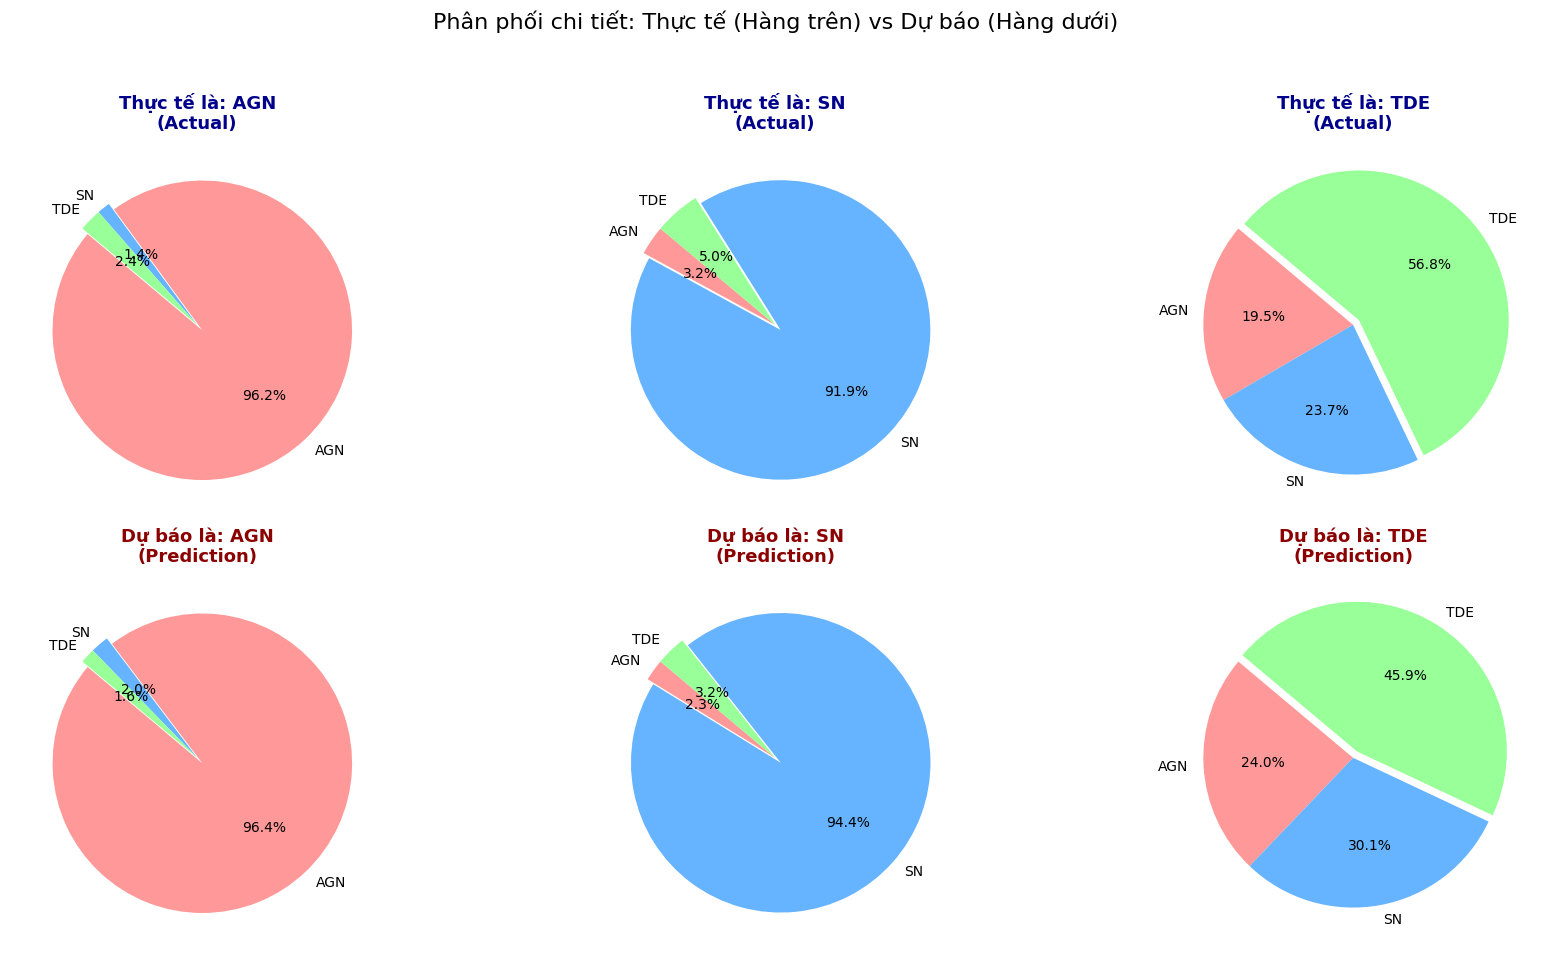

In [65]:
dist = plot_probability_distributions(oof_proba, y_cv, CLASS_NAMES, show_plot=False)
plot_prediction_confusion_pie(dist['True Label'], dist['Prediction'])

### 4.4.2. <a id='toc4_4_2_'></a>[Đánh giá trên tập test (Average Proba)](#toc0_)

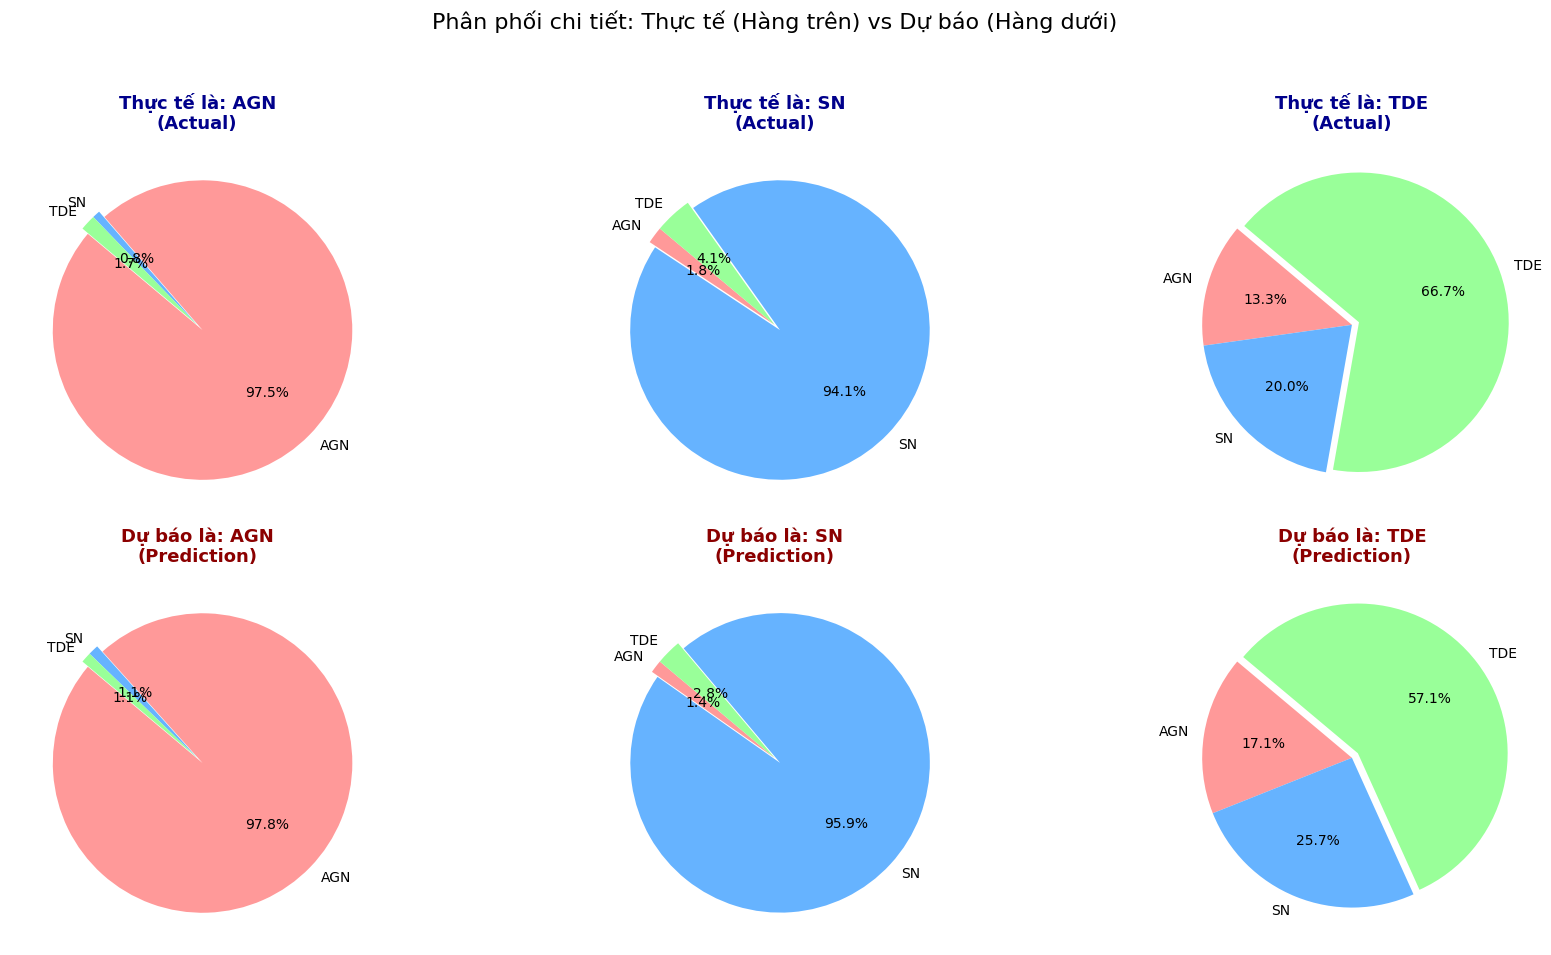

In [66]:
test_dist = plot_probability_distributions(test_proba, y_test, CLASS_NAMES, show_plot=False)
plot_prediction_confusion_pie(test_dist['True Label'], test_dist['Prediction'])

# 5. <a id='toc5_'></a>[Xuất](#toc0_)

In [68]:
test_log = pd.read_csv(path.join(dirname['root'], 'test_log.csv')).drop(columns=['English Translation'])

test_log_extracted = process_and_combine_splits(
    test_log,
    'test_full_lightcurves.csv',
    full_process
).set_index('object_id')

test_log_extracted

Extracting split_20: 100%|██████████| 358/358 [01:46<00:00,  3.37it/s]


,Z,SpecType,g_lambda_rest,i_lambda_rest,r_lambda_rest,u_lambda_rest,y_lambda_rest,z_lambda_rest,excess_variance_all,excess_variance_g,excess_variance_i,excess_variance_r,excess_variance_u,excess_variance_y,excess_variance_z,pre_median_flux,pre_flux_95th_mean,pre_detection_ratio,pre_centroid_mean,last_pre_centroid,pre_num_points,main_peak_M_abs,main_log_peak_luminosity,main_peak_flux,main_peak_lambda,main_peak_time,main_rise_time,main_fall_time,main_half_life_time,main_double_life_time,main_rise_slope,main_fall_slope,main_kurtosis,main_skew,main_amplitude_ratio,main_von_neumann,main_all_decay_alpha,main_all_tde_penalty,main_all_decay_r2,main_u_bazin_tau_fall,main_u_bazin_tau_rise,main_u_bazin_rmse,main_u_bazin_tau_fall_err,main_u_bazin_tau_rise_err,main_g_bazin_tau_fall,main_g_bazin_tau_rise,main_g_bazin_rmse,main_g_bazin_tau_fall_err,main_g_bazin_tau_rise_err,main_r_decay_alpha,main_r_tde_penalty,main_r_decay_r2,main_r_bazin_tau_fall,main_r_bazin_tau_rise,main_r_bazin_rmse,main_r_bazin_tau_fall_err,main_r_bazin_tau_rise_err,main_i_decay_alpha,main_i_tde_penalty,main_i_decay_r2,main_i_bazin_tau_fall,main_i_bazin_tau_rise,main_i_bazin_rmse,main_i_bazin_tau_fall_err,main_i_bazin_tau_rise_err,main_z_decay_alpha,main_z_tde_penalty,main_z_decay_r2,main_z_bazin_tau_fall,main_z_bazin_tau_rise,main_z_bazin_rmse,main_z_bazin_tau_fall_err,main_z_bazin_tau_rise_err,main_y_bazin_tau_fall,main_y_bazin_tau_rise,main_y_bazin_rmse,main_y_bazin_tau_fall_err,main_y_bazin_tau_rise_err,main_centroid_mean,main_delta_centroid_head,main_delta_centroid_tail,main_u_mean_weight,main_g_mean_weight,main_r_mean_weight,main_i_mean_weight,main_z_mean_weight,main_y_mean_weight,main_u_weight_ratio,main_g_weight_ratio,main_r_weight_ratio,main_i_weight_ratio,main_z_weight_ratio,main_y_weight_ratio,main_median_flux,main_flux_95th,main_mean_flux,expand_main_peak_M_abs,expand_main_log_peak_luminosity,expand_main_peak_flux,expand_main_peak_lambda,expand_main_peak_time,expand_main_rise_time,expand_main_fall_time,expand_main_half_life_time,expand_main_double_life_time,expand_main_rise_slope,expand_main_fall_slope,expand_main_kurtosis,expand_main_skew,expand_main_amplitude_ratio,expand_main_von_neumann,expand_main_all_decay_alpha,expand_main_all_tde_penalty,expand_main_all_decay_r2,expand_main_u_decay_alpha,expand_main_u_tde_penalty,expand_main_u_decay_r2,expand_main_u_bazin_tau_fall,expand_main_u_bazin_tau_rise,expand_main_u_bazin_rmse,expand_main_u_bazin_tau_fall_err,expand_main_u_bazin_tau_rise_err,expand_main_g_decay_alpha,expand_main_g_tde_penalty,expand_main_g_decay_r2,expand_main_g_bazin_tau_fall,expand_main_g_bazin_tau_rise,expand_main_g_bazin_rmse,expand_main_g_bazin_tau_fall_err,expand_main_g_bazin_tau_rise_err,expand_main_r_decay_alpha,expand_main_r_tde_penalty,expand_main_r_decay_r2,expand_main_r_bazin_tau_fall,expand_main_r_bazin_tau_rise,expand_main_r_bazin_rmse,expand_main_r_bazin_tau_fall_err,expand_main_r_bazin_tau_rise_err,expand_main_i_decay_alpha,expand_main_i_tde_penalty,expand_main_i_decay_r2,expand_main_i_bazin_tau_fall,expand_main_i_bazin_tau_rise,expand_main_i_bazin_rmse,expand_main_i_bazin_tau_fall_err,expand_main_i_bazin_tau_rise_err,expand_main_z_decay_alpha,expand_main_z_tde_penalty,expand_main_z_decay_r2,expand_main_z_bazin_tau_fall,expand_main_z_bazin_tau_rise,expand_main_z_bazin_rmse,expand_main_z_bazin_tau_fall_err,expand_main_z_bazin_tau_rise_err,expand_main_y_decay_alpha,expand_main_y_tde_penalty,expand_main_y_decay_r2,expand_main_y_bazin_tau_fall,expand_main_y_bazin_tau_rise,expand_main_y_bazin_rmse,expand_main_y_bazin_tau_fall_err,expand_main_y_bazin_tau_rise_err,expand_main_centroid_mean,expand_main_delta_centroid_head,expand_main_delta_centroid_tail,expand_main_u_mean_weight,expand_main_g_mean_weight,expand_main_r_mean_weight,expand_main_i_mean_weight,expand_main_z_mean_weight,expand_main_y_mean_weight,expand_main_u_weight_ratio,expand_main_g_weight_ratio,expand_main_r_weight_ratio,expand_main_i_weight_ratio,expand_main_z_weight_r

In [69]:
X_test_final = test_log_extracted.drop(columns=['SpecType'])

test_proba = np.zeros((len(X_test_final), lgb_params['num_class']))

for index, stored in enumerate(models_fold):
    model, confident = stored
    confident = [confident[label] for label in CLASS_NAMES]

    y_proba = model.predict_proba(X_test_final)
    y_prediction = [CLASS_NAMES[i] for i in np.argmax(y_proba, axis=1)]
    
    test_proba += y_proba / N_SPLITS


test_predictions = pd.Series([CLASS_NAMES[i] for i in np.argmax(test_proba, axis=1)], index=test_log_extracted.index)

In [70]:
test_proba = to_df(test_proba, X_test_final.index, '')
test_proba['Prediction'] = test_predictions
print('AGN: ', (test_proba['Prediction'] == 'AGN').sum())
print('TDE: ', (test_proba['Prediction'] == 'TDE').sum())
print(' SN: ', (test_proba['Prediction'] == 'SN').sum())


AGN:  4473
TDE:  217
 SN:  2445


In [ ]:
test_proba.head(50)

In [ ]:
submission = pd.DataFrame(columns=['prediction'], index=test_proba.index)
submission['prediction'] = (test_proba['Prediction'] == 'TDE').astype(int)
submission.reset_index().to_csv('Submission.csv', index=None)
submission